The data for that dataset was collected from free [IMDB Non-Commercial Datasets](https://)

Also specific data about countries, ratings from Metacritic and Rotten Tommatoes were captured from [OMDB API](https://www.omdbapi.com/)

The code to collect data is placed here: [GitHub Repository](https://github.com/sheggygal/Final-project/tree/main/api_pacckage)

[Datasets ](https://drive.google.com/drive/folders/1lIQE-26fXK2K_KeVuGanyXl3EkIhqtsj?usp=sharing) after uploading additional data

Let's begin with downloading the necessary libraries

In [2]:
!pip install fuzzywuzzy

In [3]:
import pandas as pd
import glob
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
# Download the necessary resources from nltk if you haven't done so
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Dataset creation
# Studing and filtering free datasets to get horror data and IMDB id.

In [4]:
# Load the TSV file with low_memory set to False
df = pd.read_csv('/content/title.basics.tsv', sep='\t', low_memory=False)
# Check the first few rows
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: '/content/title.basics.tsv'

In [ ]:
# Filter for movies that are classified as horror
horror_movies = df[df['genres'].str.contains('Horror', na=False)]

# Keep only relevant columns
horror_movies = horror_movies[['tconst', 'primaryTitle', 'startYear', 'genres', 'runtimeMinutes']]

print(horror_movies.head())
horror_movies.shape


        tconst                                       primaryTitle startYear  \
73   tt0000075  The Conjuring of a Woman at the House of Rober...      1896   
89   tt0000091                             The House of the Devil      1896   
129  tt0000131                                   A Terrible Night      1896   
135  tt0000138                                  The Bewitched Inn      1897   
149  tt0000152                         The Hallucinated Alchemist      1897   

                   genres runtimeMinutes  
73           Horror,Short              1  
89           Horror,Short              3  
129   Comedy,Horror,Short              1  
135   Comedy,Horror,Short              2  
149  Fantasy,Horror,Short              2  


(200486, 5)

In [ ]:
data = pd.read_csv('/content/title.ratings.tsv', sep='\t', low_memory=False)
# Check the first few rows
print(data.head())

      tconst  averageRating  numVotes
0  tt0000001            5.7      2085
1  tt0000002            5.6       283
2  tt0000003            6.5      2089
3  tt0000004            5.4       184
4  tt0000005            6.2      2822


In [ ]:
# Merge the two datasets on the 'tconst' column
# 'how' parameter set to 'left' to keep all rows from horror_movies and add ratings info where available
merged_df = pd.merge(horror_movies, data[['tconst', 'averageRating', 'numVotes']], on='tconst', how='left')

# Check the result
print(merged_df.head())

      tconst                                       primaryTitle startYear  \
0  tt0000075  The Conjuring of a Woman at the House of Rober...      1896   
1  tt0000091                             The House of the Devil      1896   
2  tt0000131                                   A Terrible Night      1896   
3  tt0000138                                  The Bewitched Inn      1897   
4  tt0000152                         The Hallucinated Alchemist      1897   

                 genres runtimeMinutes  averageRating  numVotes  
0          Horror,Short              1            6.3    2096.0  
1          Horror,Short              3            6.7    4082.0  
2   Comedy,Horror,Short              1            5.7    1560.0  
3   Comedy,Horror,Short              2            6.4    1253.0  
4  Fantasy,Horror,Short              2            6.2     298.0  


In [ ]:
merged_df.isna().sum()

,0
tconst,0
primaryTitle,0
startYear,0
genres,0
runtimeMinutes,0
averageRating,138713
numVotes,138713


In [ ]:
merged_df.fillna(0.0, inplace=True)

merged_df.isna().sum()

,0
tconst,0
primaryTitle,0
startYear,0
genres,0
runtimeMinutes,0
averageRating,0
numVotes,0


In [ ]:
merged_df.to_csv('horror_movies.csv', index=False)

# 2. Cleaning and preprocessing dataset with data, uploaded through OMDB API.

In [62]:
# Adjust the path if necessary (e.g., '/path/to/your/files/')
path = '/content/horror_data/updated_horror_movies_chunk_*.csv'

# Use glob to get all the CSV files that match the pattern
all_files = glob.glob(path)

# List to hold individual DataFrames
dfs = []

# Loop through the list of files and read them into DataFrames
for filename in all_files:
    df = pd.read_csv(filename)
    dfs.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames into one
data_raw = pd.concat(dfs, ignore_index=True)

# Reset the index if needed
data_raw.reset_index(drop=True, inplace=True)

# Display the shape of the combined DataFrame
print(f"Combined DataFrame shape: {data_raw.shape}")

# Display the first few rows of the combined DataFrame
print(data_raw.head())

Combined DataFrame shape: (200486, 18)
       tconst                                   primaryTitle startYear  \
0  tt21929830      The Impossible Quiz (2) - RAGE CONTINUES!      2014   
1  tt21929858  Eyes The Horror Game - CASUAL COMPLETE ENDING      2014   
2  tt21929878                         A Quick Thank You Vlog      2014   
3  tt21929954     The Impossible Quiz (3)- Losing My Cool...      2014   
4  tt21930138          My Top 5 Anime List - BF4 Gameplay #5      2014   

                 genres runtimeMinutes  averageRating  numVotes  \
0  Action,Comedy,Horror             10            0.0       0.0   
1  Action,Comedy,Horror             12            0.0       0.0   
2  Action,Comedy,Horror              3            0.0       0.0   
3  Action,Comedy,Horror              9            0.0       0.0   
4  Action,Comedy,Horror              9            0.0       0.0   

  ProductionBudget BoxOffice Awards PlotKeywords ProductionStudio Country  \
0              NaN       NaN    NaN 

In [6]:
# Print basic information about dataset
print(data_raw.info())
print(data_raw.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200486 entries, 0 to 200485
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tconst            200486 non-null  object 
 1   primaryTitle      200486 non-null  object 
 2   startYear         200486 non-null  object 
 3   genres            200486 non-null  object 
 4   runtimeMinutes    200486 non-null  object 
 5   averageRating     200486 non-null  float64
 6   numVotes          200486 non-null  float64
 7   ProductionBudget  1505 non-null    object 
 8   BoxOffice         1505 non-null    object 
 9   Awards            12980 non-null   object 
 10  PlotKeywords      92672 non-null   object 
 11  ProductionStudio  266 non-null     object 
 12  Country           101808 non-null  object 
 13  Metascore         1783 non-null    float64
 14  tomatoRating      11 non-null      float64
 15  tomatoUserRating  49 non-null      float64
 16  Rated             23

In [7]:
#Check for Null values
print(data_raw.isna().sum())

tconst                   0
primaryTitle             0
startYear                0
genres                   0
runtimeMinutes           0
averageRating            0
numVotes                 0
ProductionBudget    198981
BoxOffice           198981
Awards              187506
PlotKeywords        107814
ProductionStudio    200220
Country              98678
Metascore           198703
tomatoRating        200475
tomatoUserRating    200437
Rated               176817
Rating              159742
dtype: int64


In [8]:
# Clean Null Values
# Replace null values in 'ProductionBudget', 'BoxOffice', and 'Awards' columns with 0.0
data_raw['ProductionBudget'].fillna(0.0, inplace=True)
data_raw['BoxOffice'].fillna(0.0, inplace=True)
data_raw['Metascore'].fillna(0.0, inplace=True)
data_raw['tomatoRating'].fillna(0.0, inplace=True)
data_raw['tomatoUserRating'].fillna(0.0, inplace=True)
data_raw['Rating'].fillna(0.0, inplace=True)

# Replace null values in 'PlotKeywords' and 'ProductionStudio' columns with 'No'
data_raw['PlotKeywords'].fillna('No', inplace=True)
data_raw['ProductionStudio'].fillna('No', inplace=True)
data_raw['Country'].fillna('No', inplace=True)
data_raw['Awards'].fillna('No', inplace=True)
data_raw['Rated'].fillna('No', inplace=True)

# Check if there are any remaining null values
print(data_raw.isna().sum())

tconst              0
primaryTitle        0
startYear           0
genres              0
runtimeMinutes      0
averageRating       0
numVotes            0
ProductionBudget    0
BoxOffice           0
Awards              0
PlotKeywords        0
ProductionStudio    0
Country             0
Metascore           0
tomatoRating        0
tomatoUserRating    0
Rated               0
Rating              0
dtype: int64


Let's make numerical columns for awards and nominations

In [9]:
def extract_awards(award_string):
    # Check if award_string is a string before processing
    if isinstance(award_string, str):  # If it's a string, proceed as before
        wins = nominations = 0
        award_string = award_string.replace('won', '').replace('Won', '').replace('Nominated', '').strip()
        parts = award_string.split('&')
        for part in parts:
            part = part.strip()
            # Split the part by spaces and check if the first element is a number
            split_part = part.split()
            if len(split_part) > 0 and split_part[0].isdigit(): #Added conditional check to ensure that split_part[0] is a digit string before converting to int.
                if 'win' in part:
                    wins = int(split_part[0])
                elif 'nomination' in part:
                    nominations = int(split_part[0])
        return pd.Series([wins, nominations])
    else:  # If not a string (likely a float or NaN), return 0 for wins and nominations
        return pd.Series([0, 0])

# Apply function to 'Awards' column of 'data_raw' DataFrame
data_raw[['awardsClean', 'nominationsClean']] = data_raw['Awards'].apply(extract_awards) # Changed df to data_raw

# Display the resulting DataFrame
print(data_raw)

            tconst                                       primaryTitle  \
0       tt21929830          The Impossible Quiz (2) - RAGE CONTINUES!   
1       tt21929858      Eyes The Horror Game - CASUAL COMPLETE ENDING   
2       tt21929878                             A Quick Thank You Vlog   
3       tt21929954         The Impossible Quiz (3)- Losing My Cool...   
4       tt21930138              My Top 5 Anime List - BF4 Gameplay #5   
...            ...                                                ...   
200481  tt21929614                              2000 - Reintroduction   
200482  tt21929640          Scary Story Time! - Bong Chong Dong Ghost   
200483  tt21929664  HOW I LOST A GIRLFRIEND (Via TEXT MESSAGE!!) -...   
200484  tt21929690       HOT SAUCE - Food Challenge #1 - Unfair Mario   
200485  tt21929794                 Ok-Su Station Ghost w/ MrCoryPasta   

       startYear                genres runtimeMinutes  averageRating  \
0           2014  Action,Comedy,Horror             

Now let's create the column is_high to filter out movies with highest awards and nominations

In [10]:
#Create a column is_high for main moovie awards in the world

# Define the list of keywords for prestigious awards
keywords = [
    'Oscar', 'Emmy', 'BAFTA',
    'Golden Globe', 'Cannes Film Festival',
    'Berlin Film Festival', 'Venice Film Festival'
]

# Function to check for keywords
def check_awards(awards_str):
    return 1 if any(keyword in awards_str for keyword in keywords) else 0

# Apply the function to create a new column 'is_high'
data_raw['is_high'] = data_raw['Awards'].apply(check_awards)

# Display the DataFrame
print(data_raw[['Awards', 'is_high']])

       Awards  is_high
0          No        0
1          No        0
2          No        0
3          No        0
4          No        0
...       ...      ...
200481     No        0
200482     No        0
200483     No        0
200484     No        0
200485     No        0

[200486 rows x 2 columns]


In [11]:
print(data_raw['Awards'].unique())

print (data_raw['awardsClean'].unique())
print (data_raw['nominationsClean'].unique())

['No' '4 wins & 16 nominations' '1 win' '2 nominations'
 '1 win & 3 nominations' '3 wins & 4 nominations' '6 wins & 7 nominations'
 '1 nomination' '7 wins & 4 nominations' '4 wins' '1 win & 1 nomination'
 '2 wins' '6 wins' '1 win & 4 nominations' '6 nominations'
 '5 wins & 1 nomination' '2 wins & 1 nomination' '1 win.'
 '17 wins & 1 nomination' '3 nominations' '1 win & 2 nominations'
 '1 nomination.' '3 wins & 2 nominations' '4 nominations' '10 wins'
 '5 wins & 4 nominations' '1 win & 8 nominations' '2 nominations.'
 '14 wins & 26 nominations' '3 wins & 1 nomination'
 '3 wins & 3 nominations' '3 wins' '1 win & 5 nominations'
 '6 wins & 3 nominations' '16 nominations' '2 wins & 5 nominations'
 '7 wins & 3 nominations' '3 wins.' '7 nominations'
 '4 wins & 4 nominations' '5 wins' '2 wins.' '1 win & 5 nominations.'
 '3 wins & 16 nominations' '2 wins & 6 nominations'
 '2 wins & 3 nominations'
 'Nominated for 1 Primetime Emmy. 27 wins & 59 nominations total'
 '3 wins & 8 nominations' '1 win 

In [12]:
data_raw = data_raw.drop(columns=['Awards'])

In [18]:
print(data_raw['startYear'].value_counts())

startYear
\N      23858
2019    11028
2021    10955
2018    10500
2020    10063
        ...  
1906        2
1904        1
2027        1
2030        1
1905        1
Name: count, Length: 134, dtype: int64


In [20]:
count_2016 = (data_raw['startYear'] == '2016').sum()
print(count_2016)

8691


Convert data into proper format and check for the values

In [21]:
data_raw['startYear'] = pd.to_numeric(data_raw['startYear'], errors='coerce').astype('Int64')

startYear    0
dtype: int64


In [23]:
print(data_raw['startYear'].value_counts().to_dict())

{2019: 11028, 2021: 10955, 2018: 10500, 2020: 10063, 2017: 9950, 2022: 9651, 2023: 9098, 2016: 8691, 2015: 8403, 2014: 7787, 2013: 6812, 2012: 6283, 2011: 5526, 2024: 5284, 2010: 4467, 2009: 3619, 2008: 2585, 2007: 2424, 2004: 2398, 2006: 2187, 2005: 1858, 2003: 1362, 1995: 1277, 2000: 1198, 2002: 1105, 1983: 1095, 2001: 1052, 1989: 998, 1999: 987, 1997: 952, 1971: 934, 1970: 928, 1982: 891, 1972: 880, 1973: 872, 1998: 865, 1980: 860, 1981: 857, 1996: 792, 1990: 787, 1988: 775, 1975: 757, 1976: 756, 1979: 752, 1977: 750, 1974: 740, 1987: 738, 1969: 736, 1985: 723, 1991: 710, 1978: 699, 1984: 680, 1986: 669, 1968: 627, 1992: 610, 1965: 580, 1994: 551, 1964: 534, 1993: 533, 1966: 515, 1967: 500, 1958: 488, 1963: 373, 2025: 346, 1957: 323, 1959: 322, 1956: 276, 1960: 247, 1962: 225, 1961: 189, 1954: 172, 1952: 148, 1951: 140, 1950: 119, 1953: 111, 1955: 90, 1949: 77, 1920: 29, 1946: 29, 1943: 28, 1939: 27, 1944: 26, 2026: 26, 1945: 26, 1942: 25, 1932: 24, 1935: 24, 1933: 23, 1911: 21, 194

In [24]:
# Convert startYear to datetime
data_raw['startYear'] = pd.to_datetime(data_raw['startYear'], format='%Y', errors='coerce')

# Convert runtimeMinutes to integer, replace 'None' or invalid values with NaN and then convert
data_raw['runtimeMinutes'] = pd.to_numeric(data_raw['runtimeMinutes'], errors='coerce').astype('Int64')

# Convert ProductionBudget and BoxOffice to float, replacing invalid entries with NaN
data_raw['ProductionBudget'] = pd.to_numeric(data_raw['ProductionBudget'], errors='coerce')
data_raw['BoxOffice'] = pd.to_numeric(data_raw['BoxOffice'], errors='coerce')

print(data_raw.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200486 entries, 0 to 200485
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   tconst            200486 non-null  object        
 1   primaryTitle      200486 non-null  object        
 2   startYear         176628 non-null  datetime64[ns]
 3   genres            200486 non-null  object        
 4   runtimeMinutes    100280 non-null  Int64         
 5   averageRating     200486 non-null  float64       
 6   numVotes          200486 non-null  float64       
 7   ProductionBudget  198981 non-null  float64       
 8   BoxOffice         198981 non-null  float64       
 9   PlotKeywords      200486 non-null  object        
 10  ProductionStudio  200486 non-null  object        
 11  Country           200486 non-null  object        
 12  Metascore         200486 non-null  float64       
 13  tomatoRating      200486 non-null  float64       
 14  toma

We have adjusted the format of numerical and time columns. Let's move to runtimeMinutes imputation

In [25]:
# Fill in null values with median in 'runtimeMinutes' column
data_raw['runtimeMinutes'].fillna(data_raw['runtimeMinutes'].median(), inplace=True)

# Check the result
print(data_raw['runtimeMinutes'].isnull().sum())

0


In [26]:
print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200486 entries, 0 to 200485
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   tconst            200486 non-null  object        
 1   primaryTitle      200486 non-null  object        
 2   startYear         176628 non-null  datetime64[ns]
 3   genres            200486 non-null  object        
 4   runtimeMinutes    200486 non-null  Int64         
 5   averageRating     200486 non-null  float64       
 6   numVotes          200486 non-null  float64       
 7   ProductionBudget  198981 non-null  float64       
 8   BoxOffice         198981 non-null  float64       
 9   PlotKeywords      200486 non-null  object        
 10  ProductionStudio  200486 non-null  object        
 11  Country           200486 non-null  object        
 12  Metascore         200486 non-null  float64       
 13  tomatoRating      200486 non-null  float64       
 14  toma

We decided to leave empty values for startYear, cause we don't have enough data to predict all the years even decades correctly - neither plotwords to extract keywords and subgenres, nor team info.

In [ ]:
data_raw['ProductionBudget'].unique()

array([ 0., nan])

In [27]:
data_raw['BoxOffice'].unique()

array([ 0., nan])

In [29]:
data_raw['Rated'].unique()

array(['TV-14', 'No', 'Not Rated', 'R', 'TV-PG', 'TV-MA', 'K-15', 'PG-13',
       'Unrated', 'UNRATED', 'NC-17', 'PG', '18+', 'NOT RATED', 'M', 'G',
       'TV-G', '12', 'A', 'APPROVED', '16+', 'X', 'K-18', 'T', 'AO', 'E',
       'Approved', '13+', '18', 'E10+', '-12', '-16', 'GP', '(Banned)',
       'TV-13', '16', '9', '12A', '7', 'TV-Y7', 'TV-Y', '15', 'MA-17',
       'MA-13', 'Passed', 'M/PG', 'BPjM Restricted', 'II', 'EM', 'III',
       'TV-Y7-FV', 'IIB', 'R-18', '14A', 'NR', 'B15', '13', 'U'],
      dtype=object)

Let's change the ratings, implemented in each country, according to age group and restrictions, for values with no data we keep a separate key to filter out in Power BI

In [47]:
ratings_by_age_group = {
    'All Ages': [
        'G', 'TV-G', 'TV-Y', 'TV-Y7', 'E', 'Approved', 'APPROVED', 'EM', 'U', 'Passed'
    ],
    '7+': [
        'TV-Y7-FV', '7'
    ],
    '9+': [
        '9'
    ],
    '12+': [
        '12', '12A', 'IIA', '-12'
    ],
    '13+': [
        'PG', 'PG-13', 'TV-PG', '13+', 'T', 'M', 'M/PG'
    ],
    '14+': [
        'TV-14', '14A'
    ],
    '15+': [
        '15', 'B15', 'K-15', 'IIB'
    ],
    '16+': [
        '16', '16+', '-16'
    ],
    '18+': [
        'R', '18', '18+', 'K-18', 'NC-17', 'X', 'R-18'
    ],
    'Restricted/Banned': [
        'AO', '(Banned)', 'BPjM Restricted'
    ],
    'Unrated': [
        'Unrated', 'UNRATED', 'Not Rated', 'NOT RATED', 'NR'
    ],
    'No': ['No']
}

ratings_by_age_group = {k: [x.lower() for x in v] for k, v in ratings_by_age_group.items()}

In [35]:
# Replace convert all other values to lowercase
data_raw['Rated'] = data_raw['Rated'].str.lower()

In [48]:
# Map the Rated column to the lowercased dictionary
data_raw['Rated Group'] = data_raw['Rated'].apply(lambda x: next((k for k, v in ratings_by_age_group.items() if x in v), 'NaN'))

# Check the result
print(data_raw[['Rated', 'Rated Group']].head())

   Rated Rated Group
0  tv-14         14+
1  tv-14         14+
2  tv-14         14+
3  tv-14         14+
4  tv-14         14+


In [51]:
data_raw = data_raw.drop(columns=['Rating'])

In [50]:
data_raw = data_raw.drop(columns=['Rated'])

In [49]:
# Clean 'Country'
# Mapping of modern country names and their variations to standardized names
country_mapping = {
    'United States': 'US',
    'USA': 'US',
    'US': 'US',
    'United Kingdom': 'UK',
    'UK': 'UK',
    'England': 'UK'
}

# Function to clean country names
def clean_country(country_str):
    # Split compound country entries by comma
    countries = [country.strip() for country in country_str.split(',')]

    cleaned_countries = []
    for country in countries:
        # Replace using the mapping, if found, else keep the original
        cleaned_countries.append(country_mapping.get(country, country))

    # Join back into a single string for compound country entries
    return ', '.join(cleaned_countries)

# Apply the cleaning function to the 'Country' column
data_raw['Country'] = data_raw['Country'].apply(clean_country)

# Show the cleaned DataFrame
print(data_raw.head())

       tconst                                   primaryTitle  startYear  \
0  tt21929830      The Impossible Quiz (2) - RAGE CONTINUES! 2014-01-01   
1  tt21929858  Eyes The Horror Game - CASUAL COMPLETE ENDING 2014-01-01   
2  tt21929878                         A Quick Thank You Vlog 2014-01-01   
3  tt21929954     The Impossible Quiz (3)- Losing My Cool... 2014-01-01   
4  tt21930138          My Top 5 Anime List - BF4 Gameplay #5 2014-01-01   

                 genres  runtimeMinutes  averageRating  numVotes  \
0  Action,Comedy,Horror              10            0.0       0.0   
1  Action,Comedy,Horror              12            0.0       0.0   
2  Action,Comedy,Horror               3            0.0       0.0   
3  Action,Comedy,Horror               9            0.0       0.0   
4  Action,Comedy,Horror               9            0.0       0.0   

   ProductionBudget  BoxOffice PlotKeywords  ... Country Metascore  \
0               0.0        0.0           No  ...      No       0.0   



# Fearure engeniring
Now we need to extract key words and create new columns, necessary for analysis: what theme and subgenre does the film belongs to, is the film short-length or cartoon.

In [52]:
# Define a function to preprocess the plot summary text and extract keywords
def extract_keywords(plot_summary):
    if not isinstance(plot_summary, str):  # Ensure it's valid text
        return 'No'

    # Tokenization: Convert the text into individual words (tokens)
    tokens = word_tokenize(plot_summary.lower())  # Convert to lowercase

    # Remove punctuation and stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Lemmatization: Reduce words to their base form
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Return keywords as a space-separated string
    return ' '.join(tokens)

# Apply the extract_keywords function to the 'PlotKeywords' column
data_raw['ExtractedKeywords'] = data_raw['PlotKeywords'].apply(extract_keywords)

print(data_raw.head())


       tconst                                   primaryTitle  startYear  \
0  tt21929830      The Impossible Quiz (2) - RAGE CONTINUES! 2014-01-01   
1  tt21929858  Eyes The Horror Game - CASUAL COMPLETE ENDING 2014-01-01   
2  tt21929878                         A Quick Thank You Vlog 2014-01-01   
3  tt21929954     The Impossible Quiz (3)- Losing My Cool... 2014-01-01   
4  tt21930138          My Top 5 Anime List - BF4 Gameplay #5 2014-01-01   

                 genres  runtimeMinutes  averageRating  numVotes  \
0  Action,Comedy,Horror              10            0.0       0.0   
1  Action,Comedy,Horror              12            0.0       0.0   
2  Action,Comedy,Horror               3            0.0       0.0   
3  Action,Comedy,Horror               9            0.0       0.0   
4  Action,Comedy,Horror               9            0.0       0.0   

   ProductionBudget  BoxOffice PlotKeywords ProductionStudio Country  \
0               0.0        0.0           No               No      No

In [53]:
data_raw.drop(columns=['PlotKeywords'])

,tconst,primaryTitle,startYear,genres,runtimeMinutes,averageRating,numVotes,ProductionBudget,BoxOffice,ProductionStudio,Country,Metascore,tomatoRating,tomatoUserRating,awardsClean,nominationsClean,is_high,Rated Group,ExtractedKeywords
0,tt21929830,The Impossible Quiz (2) - RAGE CONTINUES!,2014-01-01,"Action,Comedy,Horror",10,0.0,0.0,0.0,0.0,No,No,0.0,0.0,0.0,0,0,0,14+,
1,tt21929858,Eyes The Horror Game - CASUAL COMPLETE ENDING,2014-01-01,"Action,Comedy,Horror",12,0.0,0.0,0.0,0.0,No,No,0.0,0.0,0.0,0,0,0,14+,
2,tt21929878,A Quick Thank You Vlog,2014-01-01,"Action,Comedy,Horror",3,0.0,0.0,0.0,0.0,No,No,0.0,0.0,0.0,0,0,0,14+,
3,tt21929954,The Impossible Quiz (3)- Losing My Cool...,2014-01-01,"Action,Comedy,Horror",9,0.0,0.0,0.0,0.0,No,No,0.0,0.0,0.0,0,0,0,14+,
4,tt21930138,My Top 5 Anime List - BF4 Gameplay #5,2014-01-01,"Action,Comedy,Horror",9,0.0,0.0,0.0,0.0,No,No,0.0,0.0,0.0,0,0,0,14+,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200481,tt21929614,2000 - Reintroduction,2014-01-01,"Action,Comedy,Horror",4,0.0,0.0,0.0,0.0,No,No,0.0,0.0,0.0,0,0,0,14+,
200482,tt21929640,Scary Story Time! - Bong Chong Dong Ghost,2014-01-01,"Action,Comedy,Horror",5,0.0,0.0,0.0,0.0,No,No,0.0,0.0,0.0,0,0,0,14+,
200483,tt21929664,HOW I LOST A GIRLFRIEND (Via TEXT MESSAGE!!) -...,2014-01-01,"Action,Comedy,Horror",10,0.0,0.0,0.0,0.0,No,No,0.0,0.0,0.0,0,0,0,14+,
200484,tt21929690,HOT SAUCE - Food Challenge #1 - Unfair Mario,2014-01-01,"Action,Comedy,Horror",9,0.0,0.0,0.0,0.0,No,No,0.0,0.0,0.0,0,0,0,14+,


We delited  column with plot, cause we don't need it for next steps.
Now let's extract the token's from title to process for genre and theme analytics

In [54]:
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to process the primary title
def process_title(title):
    # Tokenize the title
    tokens = word_tokenize(title.lower())
    # Remove stopwords and lemmatize the remaining words
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    # Join tokens back into a single string
    return ' '.join(lemmatized_tokens)

# Apply the function to the 'primaryTitle' column and create 'titleExtracted'
data_raw['titleExtracted'] = data_raw['primaryTitle'].apply(process_title)

# Check the results
print(data_raw[['primaryTitle', 'titleExtracted']].head())

                                    primaryTitle  \
0      The Impossible Quiz (2) - RAGE CONTINUES!   
1  Eyes The Horror Game - CASUAL COMPLETE ENDING   
2                         A Quick Thank You Vlog   
3     The Impossible Quiz (3)- Losing My Cool...   
4          My Top 5 Anime List - BF4 Gameplay #5   

                             titleExtracted  
0  impossible quiz ( 2 ) - rage continues !  
1  eye horror game - casual complete ending  
2                          quick thank vlog  
3   impossible quiz ( 3 ) - losing cool ...  
4       top 5 anime list - bf4 gameplay # 5  


Now let's extract tokens from genre column

In [55]:
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to process the genre column
def process_genres(genre):
    # Tokenize the title
    tokens = word_tokenize(genre.lower())
    # Remove stopwords and lemmatize the remaining words
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    # Join tokens back into a single string
    return ' '.join(lemmatized_tokens)

# Apply the function to the 'primaryTitle' column and create 'genresExtracted'
data_raw['genresExtracted'] = data_raw['genres'].apply(process_title)

# Check the results
print(data_raw[['genres', 'genresExtracted']].head())

                 genres           genresExtracted
0  Action,Comedy,Horror  action , comedy , horror
1  Action,Comedy,Horror  action , comedy , horror
2  Action,Comedy,Horror  action , comedy , horror
3  Action,Comedy,Horror  action , comedy , horror
4  Action,Comedy,Horror  action , comedy , horror


In [56]:
print(data_raw['genresExtracted'].unique())

['action , comedy , horror' 'horror , sci-fi' 'horror'
 'drama , horror , romance' 'drama , horror , mystery'
 'drama , fantasy , horror' 'horror , mystery , short' 'horror , thriller'
 'horror , short' 'horror , romance , thriller' 'comedy , horror'
 'horror , sci-fi , short' 'comedy , horror , short' 'action , horror'
 'horror , mystery , thriller' 'action , horror , thriller'
 'animation , horror , short' 'documentary , horror'
 'drama , horror , short' 'horror , talk-show'
 'animation , drama , horror' 'horror , short , thriller'
 'documentary , history , horror' 'comedy , family , horror'
 'animation , horror' 'action , adventure , horror'
 'comedy , horror , sci-fi' 'animation , horror , sci-fi'
 'horror , sci-fi , thriller' 'biography , horror , talk-show'
 'comedy , drama , horror' 'horror , mystery , sci-fi'
 'animation , comedy , horror' 'comedy , horror , reality-tv'
 'action , fantasy , horror' 'adventure , fantasy , horror'
 'adventure , horror , thriller' 'crime , fantasy

Let's make sub-genre clasification feature.

In [57]:
# Define keywords for each horror subgenre
subgenre_keywords = {
    'Body Horror': ['transformation', 'fragmentation', 'body change', 'mutation', 'dismemberment'],
    'Christmas Horror': ['Christmas', 'Santa', 'holiday', 'gift', 'Yuletide', 'mistletoe'],
    'Erotic Horror': ['sex', 'sexual', 'erotic', 'sensual', 'gore', 'pleasure', 'adult'],
    'Folk Horror': ['folklore', 'ritual', 'cult', 'pagan', 'superstition', 'rural', 'voodoo'],
    'Found Footage Horror': ['found footage', 'camera', 'amateur', 'news' 'discovered footage', 'first-person'],
    'Gothic Horror': ['castle', 'mansion', 'haunted', 'gothic', 'vampire', 'ghost'],
    'Natural Horror': ['nature', 'animal', 'insect', 'mutant', 'eco', 'natural disaster'],
    'Psychological Horror': ['mind', 'mental', 'disquiet', 'fear', 'anxiety', 'suspense', 'thriller'],
    'Religious Horror': ['demon', 'exorcism', 'cross', 'Bible', 'holy', 'religion'],
    'Slasher Horror': ['killer', 'murder', 'slasher', 'blood', 'knife', 'axe'],
    'Supernatural Horror': ['spirit', 'ghost', 'supernatural', 'haunting', 'possession', 'afterlife'],
    'Teen Horror': ['teen', 'high school', 'teenager', 'prom', 'party', 'student'],
    'Comedy Horror': ['comedy', 'laughter', 'fun', 'dark humor', 'parody', 'jump scares', 'ridiculous death', 'hilarious scares']
}

# Function to tokenize and lemmatize the keywords
def tokenize_and_lemmatize(input_dict):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    lemmatized_dict = {}
    for category, keywords in input_dict.items():
        lemmatized_keywords = []
        for phrase in keywords:
            # Tokenize the phrase into individual words
            tokens = word_tokenize(phrase.lower())  # Convert to lowercase for consistency
            # Lemmatize each word
            lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
            # Join back to form a lemmatized phrase and append to the list
            lemmatized_phrase = ' '.join(lemmatized_tokens)
            lemmatized_keywords.append(lemmatized_phrase)
        # Store the lemmatized keywords for the category
        lemmatized_dict[category] = lemmatized_keywords
    return lemmatized_dict

# Apply the function to any dictionary
lemmatized_subgenre_dict = tokenize_and_lemmatize(subgenre_keywords)

for genre, keywords in lemmatized_subgenre_dict.items():
    print(f"{genre}: {keywords}")

# Function to apply fuzzy matching and classify subgenres with weights
def classify_subgenre(row, lemmatized_subgenre_dict):
    # Extract the relevant columns
    extracted_keywords = row['ExtractedKeywords']
    title_extracted = row['titleExtracted']
    genres_extracted = row['genresExtracted']

    # Initialize an empty dictionary to store the subgenre matches and their scores
    subgenre_scores = {subgenre: 0 for subgenre in lemmatized_subgenre_dict}

    # Step 1: If a genre is detected in 'genresExtracted', it goes directly to the subgenre
    if genres_extracted in lemmatized_subgenre_dict:
        detected_subgenre = genres_extracted
        subgenre_scores[detected_subgenre] = 9999  # Assign an arbitrary high score for default assignment

    # Step 2: Match keywords from 'titleExtracted' and 'ExtractedKeywords' using fuzzy matching
    for col_keywords in [title_extracted, extracted_keywords]:
        for subgenre, keywords in lemmatized_subgenre_dict.items():
            for keyword in keywords:
                # Use fuzzy matching to compare the subgenre keywords with the extracted ones
                match_ratio = fuzz.partial_ratio(keyword, col_keywords)
                if match_ratio > 70:  # Use a threshold of 70 for reasonable fuzzy matches
                    subgenre_scores[subgenre] += match_ratio

    # Step 3: Sort subgenres by their match scores
    sorted_subgenres = sorted(subgenre_scores.items(), key=lambda x: x[1], reverse=True)

    # Step 4: Select the two most common subgenres
    top_two_subgenres = [subgenre for subgenre, score in sorted_subgenres[:2] if score > 0]

    # Step 5: Handle cases where the top subgenre matches the default extracted subgenre
    if genres_extracted in top_two_subgenres:
        top_two_subgenres.remove(genres_extracted)  # Remove default subgenre if it appears in the top matches
        top_two_subgenres = [genres_extracted] + top_two_subgenres  # Ensure default is listed first

    # Step 6: If no subgenres are found, return 'No' or the top two most common ones
    return top_two_subgenres if top_two_subgenres else ['No']

# Apply the function to the DataFrame
data_raw['DetectedSubgenres'] = data_raw.apply(lambda row: classify_subgenre(row, lemmatized_subgenre_dict), axis=1)

# Check the results
print(data_raw[['primaryTitle', 'titleExtracted', 'ExtractedKeywords', 'DetectedSubgenres']].head())

Body Horror: ['transformation', 'fragmentation', 'body change', 'mutation', 'dismemberment']
Christmas Horror: ['christmas', 'santa', 'holiday', 'gift', 'yuletide', 'mistletoe']
Erotic Horror: ['sex', 'sexual', 'erotic', 'sensual', 'gore', 'pleasure', 'adult']
Folk Horror: ['folklore', 'ritual', 'cult', 'pagan', 'superstition', 'rural', 'voodoo']
Found Footage Horror: ['found footage', 'camera', 'amateur', 'newsdiscovered footage', 'first-person']
Gothic Horror: ['castle', 'mansion', 'haunted', 'gothic', 'vampire', 'ghost']
Natural Horror: ['nature', 'animal', 'insect', 'mutant', 'eco', 'natural disaster']
Psychological Horror: ['mind', 'mental', 'disquiet', 'fear', 'anxiety', 'suspense', 'thriller']
Religious Horror: ['demon', 'exorcism', 'cross', 'bible', 'holy', 'religion']
Slasher Horror: ['killer', 'murder', 'slasher', 'blood', 'knife', 'axe']
Supernatural Horror: ['spirit', 'ghost', 'supernatural', 'haunting', 'possession', 'afterlife']
Teen Horror: ['teen', 'high school', 'teena

Creating feature to extract theme

In [58]:
# Define keywords for each antagonist type
antagonist_keywords = {
    'Vampires': ['vampire', 'strigoi', 'dracula', 'bloodsucker'],
    'Werewolf':['werewolf', 'wolf', 'licantrop', 'shifter'],
    'Zombies':['zombie', 'undead', 'walker', 'shambler', 'infected', 'ghoul', 'flesh-eater', 'living dead'],
    'Alien': ['alien', 'space', 'planet','creature', 'extraterrestrial', 'spaceship', 'UFO', 'alien invasion'],
    'Monsters': ['creature', 'beast', 'monster'],
    'Ghosts and Spirits': ['ghost', 'spirit', 'haunt', 'phantom', 'apparition', 'specter', 'poltergeist'],
    'Serial Killers': ['serial killer', 'murderer', 'killer', 'slasher', 'psychopath', 'childhood'],
    'Demons and Possessed Individuals': ['demon', 'possession', 'possessed', 'evil entity', 'satanic'],
    'Psychological Tormentors': ['psychological', 'manipulation', 'gaslighting', 'mind games', 'mental torture'],
    'Cults and Fanatical Groups': ['cult', 'sect', 'ritual', 'sacrifice', 'fanatic'],
    'Natural Forces': ['animal attack', 'nature', 'weather', 'storm', 'beast', 'natural disaster'],
    'Artificial and Technological Threats': ['robot', 'AI', 'technology', 'machine', 'cyber', 'tech'],
    'Dystopian or Corrupt Authority Figures': ['totalitarian', 'dictator', 'authority', 'corrupt', 'regime'],
    'Mythological and Legendary Beings': ['krampus', 'banshee', 'legend', 'myth', 'folklore', 'mythological']
}

# Apply the function to any dictionary
lemmatized_theme_dict = tokenize_and_lemmatize(antagonist_keywords)

for genre, keywords in lemmatized_theme_dict.items():
    print(f"{genre}: {keywords}")

# Function to apply fuzzy matching and classify themes with weights
def classify_theme(row, lemmatized_theme_dict):
    # Extract the relevant columns
    extracted_keywords = row['ExtractedKeywords']
    title_extracted = row['titleExtracted']
    genres_extracted = row['genresExtracted']

    # Initialize an empty dictionary to store theme matches and their scores
    theme_scores = {theme: 0 for theme in lemmatized_theme_dict}

    # Step 1: If a theme is detected in 'titleExtracted', assign it with a high weight (by default)
    for theme, keywords in lemmatized_theme_dict.items():
        if any(keyword in title_extracted for keyword in keywords):
            theme_scores[theme] = 9999  # Assign high score for default theme from title

    # Step 2: Fuzzy match keywords from 'ExtractedKeywords' using fuzzy matching
    for theme, keywords in lemmatized_theme_dict.items():
        for keyword in keywords:
            # Use fuzzy matching to compare theme keywords with the extracted ones from 'ExtractedKeywords'
            match_ratio = fuzz.partial_ratio(keyword, extracted_keywords)
            if match_ratio > 70:  # Use a threshold of 70 for reasonable fuzzy matches
                theme_scores[theme] += match_ratio

    # Step 3: Sort themes by their match scores
    sorted_themes = sorted(theme_scores.items(), key=lambda x: x[1], reverse=True)

    # Step 4: Select the top two most relevant themes based on scores
    top_two_themes = [theme for theme, score in sorted_themes[:2] if score > 0]

    # Step 5: Check if one of the themes matches the default one from 'titleExtracted'
    default_theme_from_title = [theme for theme, score in theme_scores.items() if score == 9999]
    if default_theme_from_title:
        default_theme = default_theme_from_title[0]
        if default_theme in top_two_themes:
            top_two_themes.remove(default_theme)  # Remove it if it's already in top themes
            top_two_themes = [default_theme] + top_two_themes  # Ensure default is listed first

    # Step 6: If no themes are found, return 'No', otherwise return top two themes
    return top_two_themes if top_two_themes else ['No']

# Apply the function to the DataFrame
data_raw['DetectedThemes'] = data_raw.apply(lambda row: classify_theme(row, lemmatized_theme_dict), axis=1)

# Check the results
print(data_raw[['primaryTitle', 'titleExtracted', 'ExtractedKeywords', 'DetectedThemes']].head())



Vampires: ['vampire', 'strigoi', 'dracula', 'bloodsucker']
Werewolf: ['werewolf', 'wolf', 'licantrop', 'shifter']
Zombies: ['zombie', 'undead', 'walker', 'shambler', 'infected', 'ghoul', 'flesh-eater', 'living dead']
Alien: ['alien', 'space', 'planet', 'creature', 'extraterrestrial', 'spaceship', 'ufo', 'alien invasion']
Monsters: ['creature', 'beast', 'monster']
Ghosts and Spirits: ['ghost', 'spirit', 'haunt', 'phantom', 'apparition', 'specter', 'poltergeist']
Serial Killers: ['serial killer', 'murderer', 'killer', 'slasher', 'psychopath', 'childhood']
Demons and Possessed Individuals: ['demon', 'possession', 'possessed', 'evil entity', 'satanic']
Psychological Tormentors: ['psychological', 'manipulation', 'gaslighting', 'mind game', 'mental torture']
Cults and Fanatical Groups: ['cult', 'sect', 'ritual', 'sacrifice', 'fanatic']
Natural Forces: ['animal attack', 'nature', 'weather', 'storm', 'beast', 'natural disaster']
Artificial and Technological Threats: ['robot', 'ai', 'technology

In [59]:
# Function to clean the specified column and create theme/subgenre columns
def clean_column(dataframe, column_name, prefix):
    # Initialize new columns based on the prefix
    dataframe[f'{prefix}1'] = 'No'
    dataframe[f'{prefix}2'] = 'No'
    dataframe[f'{prefix}3'] = 'No'

    # Iterate over each row in the specified column
    for index, row in dataframe.iterrows():
        items = row[column_name]

        if len(items) > 0:
            dataframe.at[index, f'{prefix}1'] = items[0]  # First string goes to prefix1
        if len(items) > 1:
            dataframe.at[index, f'{prefix}2'] = items[1]  # Second string goes to prefix2
        if len(items) > 2:
            dataframe.at[index, f'{prefix}3'] = items[2]  # Third string goes to prefix3

# Apply the function for DetectedThemes and DetectedSubgenres
clean_column(data_raw, 'DetectedThemes', 'theme')
clean_column(data_raw, 'DetectedSubgenres', 'subgenre')

# Check the results
print(data_raw[['DetectedThemes', 'theme1', 'theme2', 'theme3']])
print(data_raw[['DetectedSubgenres', 'subgenre1', 'subgenre2', 'subgenre3']])

                                DetectedThemes  \
0                                         [No]   
1                                         [No]   
2                                         [No]   
3                                         [No]   
4                                         [No]   
...                                        ...   
200481                                    [No]   
200482                    [Ghosts and Spirits]   
200483                                    [No]   
200484  [Artificial and Technological Threats]   
200485                    [Ghosts and Spirits]   

                                      theme1 theme2 theme3  
0                                         No     No     No  
1                                         No     No     No  
2                                         No     No     No  
3                                         No     No     No  
4                                         No     No     No  
...                              

Let's create another feature 'is_short', to identify short and full length, and is_cartoon for animation.

In [60]:
# Function to check for 'short' token for is_short column
data_raw['is_short'] = data_raw['genresExtracted'].apply(lambda x: 'short' in x.lower())

# Function to check for 'animation' token for is_cartoon column
data_raw['is_cartoon'] = data_raw['genresExtracted'].apply(lambda x: 'animation' in x.lower())

# Display the DataFrame
print(data_raw[['genresExtracted', 'is_short', 'is_cartoon']])

                 genresExtracted  is_short  is_cartoon
0       action , comedy , horror     False       False
1       action , comedy , horror     False       False
2       action , comedy , horror     False       False
3       action , comedy , horror     False       False
4       action , comedy , horror     False       False
...                          ...       ...         ...
200481  action , comedy , horror     False       False
200482  action , comedy , horror     False       False
200483  action , comedy , horror     False       False
200484  action , comedy , horror     False       False
200485  action , comedy , horror     False       False

[200486 rows x 3 columns]


Let's fill in empty values for runtime minutes with the help of our is_short feature

In [67]:
# Convert runtimeMinutes to numeric, setting errors='coerce' will turn '\\N' into NaN
data_raw['runtimeMinutes'] = pd.to_numeric(data_raw['runtimeMinutes'], errors='coerce')

In [70]:
# Calculate median values for each group
median_true = data_raw[data_raw['is_short'] == True]['runtimeMinutes'].median()
median_false = data_raw[data_raw['is_short'] == False]['runtimeMinutes'].median()

# Define a function to replace '\\N' with the appropriate median
def replace_nan_with_median(row):
    if pd.isna(row['runtimeMinutes']):  # Check if the value is NaN
        if row['is_short']:
            return median_true  # Replace with median for True
        else:
            return median_false  # Replace with median for False
    return row['runtimeMinutes']  # Return the original value if not NaN

# Apply the function to the DataFrame
data_raw['runtimeMinutes'] = data_raw.apply(replace_nan_with_median, axis=1)

# Display the updated DataFrame
print(data_raw.head())

       tconst                                   primaryTitle  startYear  \
0  tt21929830      The Impossible Quiz (2) - RAGE CONTINUES! 2014-01-01   
1  tt21929858  Eyes The Horror Game - CASUAL COMPLETE ENDING 2014-01-01   
2  tt21929878                         A Quick Thank You Vlog 2014-01-01   
3  tt21929954     The Impossible Quiz (3)- Losing My Cool... 2014-01-01   
4  tt21930138          My Top 5 Anime List - BF4 Gameplay #5 2014-01-01   

   runtimeMinutes  averageRating  numVotes  ProductionBudget  BoxOffice  \
0            10.0            0.0       0.0               0.0        0.0   
1            12.0            0.0       0.0               0.0        0.0   
2             3.0            0.0       0.0               0.0        0.0   
3             9.0            0.0       0.0               0.0        0.0   
4             9.0            0.0       0.0               0.0        0.0   

  ProductionStudio Country  ...  is_high  Rated Group  theme1  theme2  theme3  \
0               N

In [61]:
# Drop the specified columns from the DataFrame
columns_to_drop = ['DetectedThemes', 'DetectedSubgenres', 'genres', 'genresExtracted', 'ExtractedKeywords', 'titleExtracted', 'PlotKeywords']
data_raw = data_raw.drop(columns=columns_to_drop)

# Display the updated DataFrame
print(data_raw.head())

       tconst                                   primaryTitle  startYear  \
0  tt21929830      The Impossible Quiz (2) - RAGE CONTINUES! 2014-01-01   
1  tt21929858  Eyes The Horror Game - CASUAL COMPLETE ENDING 2014-01-01   
2  tt21929878                         A Quick Thank You Vlog 2014-01-01   
3  tt21929954     The Impossible Quiz (3)- Losing My Cool... 2014-01-01   
4  tt21930138          My Top 5 Anime List - BF4 Gameplay #5 2014-01-01   

   runtimeMinutes  averageRating  numVotes  ProductionBudget  BoxOffice  \
0              10            0.0       0.0               0.0        0.0   
1              12            0.0       0.0               0.0        0.0   
2               3            0.0       0.0               0.0        0.0   
3               9            0.0       0.0               0.0        0.0   
4               9            0.0       0.0               0.0        0.0   

  ProductionStudio Country  ...  is_high  Rated Group  theme1  theme2  theme3  \
0               N

In [71]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200486 entries, 0 to 200485
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   tconst            200486 non-null  object        
 1   primaryTitle      200486 non-null  object        
 2   startYear         176628 non-null  datetime64[ns]
 3   runtimeMinutes    200486 non-null  float64       
 4   averageRating     200486 non-null  float64       
 5   numVotes          200486 non-null  float64       
 6   ProductionBudget  200486 non-null  float64       
 7   BoxOffice         200486 non-null  float64       
 8   ProductionStudio  200486 non-null  object        
 9   Country           200486 non-null  object        
 10  Metascore         200486 non-null  float64       
 11  tomatoRating      200486 non-null  float64       
 12  tomatoUserRating  200486 non-null  float64       
 13  awardsClean       200486 non-null  int64         
 14  nomi

In [72]:
data_raw['Country'].unique()

array(['No', 'Spain', 'Canada', ..., 'Chile, Austria',
       'Portugal, Ireland', 'Chile, Venezuela, US'], dtype=object)

Let's create a microregion feature to understand if there is a specific correlation with genres, themes and awards

In [77]:
# Define country grouping mappings with all microregions
country_grouping = {
    'MENA': ['Algeria', 'Bahrain', 'Cyprus', 'Egypt', 'Iran', 'Iraq', 'Israel',
             'Jordan', 'Kuwait', 'Lebanon', 'Libya', 'Morocco', 'Oman',
             'Palestine', 'Qatar', 'Saudi Arabia', 'Syria', 'Tunisia', 'Turkey',
             'United Arab Emirates', 'Yemen'],
    'Northern Africa': ['Sudan', 'Western Sahara'],
    'Scandinavia': ['Denmark', 'Finland', 'Iceland', 'Norway', 'Sweden'],
    'Baltic States': ['Estonia', 'Latvia', 'Lithuania'],
    'UK and Ireland': ['Ireland', 'UK'],
    'Balkans': ['Albania', 'Bosnia and Herzegovina', 'Croatia', 'Kosovo', 'Montenegro',
                'North Macedonia', 'Serbia', 'Slovenia'],
    'Southern Europe': ['Andorra', 'Greece', 'Italy', 'Malta', 'Portugal', 'San Marino', 'Spain', 'Vatican City'],
    'Western Europe': ['Austria', 'Belgium', 'France', 'Germany', 'Liechtenstein', 'Luxembourg', 'Monaco', 'Netherlands', 'Switzerland'],
    'Eastern Europe': ['Belarus', 'Bulgaria', 'Czech Republic', 'Hungary', 'Moldova', 'Poland', 'Romania', 'Russia', 'Slovakia', 'Ukraine'],
    'Western Africa': ['Benin', 'Burkina Faso', 'Cape Verde', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
                       'Liberia', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone', 'Togo'],
    'Eastern Africa': ['Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Madagascar', 'Malawi',
                       'Mauritius', 'Mozambique', 'Rwanda', 'Seychelles', 'Somalia', 'South Sudan', 'Tanzania', 'Uganda',
                       'Zambia', 'Zimbabwe'],
    'Central Africa': ['Angola', 'Cameroon', 'Central African Republic', 'Chad', 'Democratic Republic of the Congo',
                       'Republic of the Congo', 'Equatorial Guinea', 'Gabon', 'São Tomé and Príncipe'],
    'Southern Africa': ['Botswana', 'Eswatini', 'Lesotho', 'Namibia', 'South Africa'],
    'North America': ['Canada', 'Mexico', 'US'],
    'Central America': ['Belize', 'Costa Rica', 'El Salvador', 'Guatemala', 'Honduras', 'Nicaragua', 'Panama'],
    'Caribbean': ['Antigua and Barbuda', 'Bahamas', 'Barbados', 'Cuba', 'Dominica', 'Dominican Republic', 'Grenada',
                  'Haiti', 'Jamaica', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines',
                  'Trinidad and Tobago'],
    'South America': ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay',
                      'Peru', 'Suriname', 'Uruguay', 'Venezuela'],
    'East Asia': ['China', 'Japan', 'Mongolia', 'North Korea', 'South Korea', 'Taiwan'],
    'Southeast Asia': ['Brunei', 'Cambodia', 'Indonesia', 'Laos', 'Malaysia', 'Myanmar', 'Philippines',
                       'Singapore', 'Thailand', 'Timor-Leste', 'Vietnam'],
    'South Asia': ['Afghanistan', 'Bangladesh', 'Bhutan', 'India', 'Maldives', 'Nepal', 'Pakistan', 'Sri Lanka'],
    'Central Asia': ['Kazakhstan', 'Kyrgyzstan', 'Tajikistan', 'Turkmenistan', 'Uzbekistan'],
    'Western Asia': ['Armenia', 'Azerbaijan', 'Georgia'],
    'Oceania': ['Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia', 'Nauru', 'New Zealand',
                'Palau', 'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Tonga', 'Tuvalu', 'Vanuatu'],
    'Pacific Islands': ['Cook Islands', 'French Polynesia', 'New Caledonia', 'Niue', 'Pitcairn Islands', 'Tokelau', 'Wallis and Futuna']
}

In [78]:
# Function to assign regions based on countries, ensuring only the first appearance of a region is retained
def assign_regions(countries):
    assigned_regions = set()  # To keep track of assigned regions
    for country in countries:
        found = False  # Flag to indicate if a country was found in any region
        for region, region_countries in country_grouping.items():
            if country in region_countries:
                assigned_regions.add(region)  # Add the region only once
                found = True
                break  # Stop after the first appearance
        if not found:  # If no region was found, assign 'No'
            assigned_regions.add('No')
    # Return the first element if the set has elements; otherwise, return 'No'
    return list(assigned_regions)[0] if assigned_regions else 'No'

# Apply the function to assign regions
data_raw['Region'] = data_raw['Country'].apply(lambda country: assign_regions([country]))

# Show the resulting DataFrame
print(data_raw.explode('Region'))

            tconst                                       primaryTitle  \
0       tt21929830          The Impossible Quiz (2) - RAGE CONTINUES!   
1       tt21929858      Eyes The Horror Game - CASUAL COMPLETE ENDING   
2       tt21929878                             A Quick Thank You Vlog   
3       tt21929954         The Impossible Quiz (3)- Losing My Cool...   
4       tt21930138              My Top 5 Anime List - BF4 Gameplay #5   
...            ...                                                ...   
200481  tt21929614                              2000 - Reintroduction   
200482  tt21929640          Scary Story Time! - Bong Chong Dong Ghost   
200483  tt21929664  HOW I LOST A GIRLFRIEND (Via TEXT MESSAGE!!) -...   
200484  tt21929690       HOT SAUCE - Food Challenge #1 - Unfair Mario   
200485  tt21929794                 Ok-Su Station Ghost w/ MrCoryPasta   

        startYear  runtimeMinutes  averageRating  numVotes  ProductionBudget  \
0      2014-01-01            10.0          

In [79]:
data_raw['Region'].unique()

array(['No', 'Southern Europe', 'North America', 'Western Europe',
       'UK and Ireland', 'East Asia', 'South America', 'South Asia',
       'Eastern Europe', 'Scandinavia', 'Southeast Asia',
       'Southern Africa', 'Western Africa', 'MENA', 'Central America',
       'Eastern Africa', 'Baltic States', 'Balkans', 'Western Asia',
       'Caribbean', 'Central Africa', 'Central Asia'], dtype=object)

# Data normalization

In [80]:
print(data_raw.describe())
print(data_raw.info())

                           startYear  runtimeMinutes  averageRating  \
count                         176628   200486.000000  200486.000000   
mean   2009-03-04 00:57:05.613153024       45.737358       1.882738   
min              1896-01-01 00:00:00        1.000000       0.000000   
25%              2007-01-01 00:00:00       12.000000       0.000000   
50%              2015-01-01 00:00:00       60.000000       0.000000   
75%              2020-01-01 00:00:00       60.000000       4.500000   
max              2030-01-01 00:00:00     2070.000000      10.000000   
std                              NaN       32.536089       2.980459   

           numVotes  ProductionBudget  BoxOffice      Metascore  \
count  2.004860e+05          200486.0   200486.0  200486.000000   
mean   6.929041e+02               0.0        0.0       0.451498   
min    0.000000e+00               0.0        0.0       0.000000   
25%    0.000000e+00               0.0        0.0       0.000000   
50%    0.000000e+00      

We won't touch ratings. We don't have a lot of data on financial columns, so we will drop it.

Now let's transform our themes, subgenres and region data into numbers, to find the correlations easier.

In [81]:
print(data_raw.head())

       tconst                                   primaryTitle  startYear  \
0  tt21929830      The Impossible Quiz (2) - RAGE CONTINUES! 2014-01-01   
1  tt21929858  Eyes The Horror Game - CASUAL COMPLETE ENDING 2014-01-01   
2  tt21929878                         A Quick Thank You Vlog 2014-01-01   
3  tt21929954     The Impossible Quiz (3)- Losing My Cool... 2014-01-01   
4  tt21930138          My Top 5 Anime List - BF4 Gameplay #5 2014-01-01   

   runtimeMinutes  averageRating  numVotes  ProductionBudget  BoxOffice  \
0            10.0            0.0       0.0               0.0        0.0   
1            12.0            0.0       0.0               0.0        0.0   
2             3.0            0.0       0.0               0.0        0.0   
3             9.0            0.0       0.0               0.0        0.0   
4             9.0            0.0       0.0               0.0        0.0   

  ProductionStudio Country  ...  Rated Group  theme1  theme2  theme3  \
0               No      No

In [82]:
# Mapping dictionary for themes and subgenres
mapping = {
    'No': 0,
    'Vampires': 1,
    'Werewolf': 2,
    'Zombies': 3,
    'Alien': 4,
    'Monsters': 5,
    'Ghosts and Spirits': 6,
    'Serial Killers': 7,
    'Demons and Possessed Individuals': 8,
    'Psychological Tormentors': 9,
    'Cults and Fanatical Groups': 10,
    'Natural Force': 11,
    'Artificial and Technological Threats': 12,
    'Dystopian or Corrupt Authority Figures': 13,
    'Mythological and Legendary Beings': 14
}

# Transforming themes and subgenres into numerical values
def transform_theme_subgenre(value):
    if value == 'No':
        return 0
    return mapping.get(value, 0)  # Use 0 for any unmapped values
data_raw['theme1'] = data_raw['theme1'].map(mapping).fillna(0).astype(int)
data_raw['theme2'] = data_raw['theme2'].map(mapping).fillna(0).astype(int)
data_raw['theme3'] = data_raw['theme3'].map(mapping).fillna(0).astype(int)

# Display the head of the updated DataFrame
print(mapping)
print(data_raw.head())

{'No': 0, 'Vampires': 1, 'Werewolf': 2, 'Zombies': 3, 'Alien': 4, 'Monsters': 5, 'Ghosts and Spirits': 6, 'Serial Killers': 7, 'Demons and Possessed Individuals': 8, 'Psychological Tormentors': 9, 'Cults and Fanatical Groups': 10, 'Natural Force': 11, 'Artificial and Technological Threats': 12, 'Dystopian or Corrupt Authority Figures': 13, 'Mythological and Legendary Beings': 14}
       tconst                                   primaryTitle  startYear  \
0  tt21929830      The Impossible Quiz (2) - RAGE CONTINUES! 2014-01-01   
1  tt21929858  Eyes The Horror Game - CASUAL COMPLETE ENDING 2014-01-01   
2  tt21929878                         A Quick Thank You Vlog 2014-01-01   
3  tt21929954     The Impossible Quiz (3)- Losing My Cool... 2014-01-01   
4  tt21930138          My Top 5 Anime List - BF4 Gameplay #5 2014-01-01   

   runtimeMinutes  averageRating  numVotes  ProductionBudget  BoxOffice  \
0            10.0            0.0       0.0               0.0        0.0   
1            12.

In [83]:
# Define the mapping for subgenres
subgenre_mapping = {
    'Body Horror': 1,
    'Christmas Horror': 2,
    'Erotic Horror': 3,
    'Folk Horror': 4,
    'Found Footage Horror': 5,
    'Gothic Horror': 6,
    'Natural Horror': 7,
    'Psychological Horror': 8,
    'Religious Horror': 9,
    'Slasher Horror': 10,
    'Supernatural Horror': 11,
    'Teen Horror': 12,
    'Comedy Horror': 13,
    'No': 0
}

# Transform subgenres into numerical values
def transform_subgenre(value):
    if value == 'No':
        return 0
    return subgenre_mapping.get(value, 0)  # Use 0 for any unmapped values

# Apply mapping to the subgenre columns
data_raw['subgenre1'] = data_raw['subgenre1'].map(transform_subgenre).fillna(0).astype(int)
data_raw['subgenre2'] = data_raw['subgenre2'].map(transform_subgenre).fillna(0).astype(int)
data_raw['subgenre3'] = data_raw['subgenre3'].map(transform_subgenre).fillna(0).astype(int)

# Display the head of the updated DataFrame
print(subgenre_mapping)
print(data_raw.head())

{'Body Horror': 1, 'Christmas Horror': 2, 'Erotic Horror': 3, 'Folk Horror': 4, 'Found Footage Horror': 5, 'Gothic Horror': 6, 'Natural Horror': 7, 'Psychological Horror': 8, 'Religious Horror': 9, 'Slasher Horror': 10, 'Supernatural Horror': 11, 'Teen Horror': 12, 'Comedy Horror': 13, 'No': 0}
       tconst                                   primaryTitle  startYear  \
0  tt21929830      The Impossible Quiz (2) - RAGE CONTINUES! 2014-01-01   
1  tt21929858  Eyes The Horror Game - CASUAL COMPLETE ENDING 2014-01-01   
2  tt21929878                         A Quick Thank You Vlog 2014-01-01   
3  tt21929954     The Impossible Quiz (3)- Losing My Cool... 2014-01-01   
4  tt21930138          My Top 5 Anime List - BF4 Gameplay #5 2014-01-01   

   runtimeMinutes  averageRating  numVotes  ProductionBudget  BoxOffice  \
0            10.0            0.0       0.0               0.0        0.0   
1            12.0            0.0       0.0               0.0        0.0   
2             3.0           

In [85]:
# Drop the specified columns from the DataFrame
columns_to_drop = ['theme3', 'subgenre3']
data_raw = data_raw.drop(columns=columns_to_drop)

In [91]:
columns_to_drop = ['ProductionBudget', 'BoxOffice']

# 3. Exploratory data analysis

Let's study our data to find out, if there are any correlations between genre, theme, rating and number of votes and ratings. Let's also pay attention to regional distribution of that data.

In [94]:
# Create a DataFrame with only numerical columns
numerical_columns_df = data_raw.select_dtypes(include=['float64', 'int64', 'Int64'])

# Generate descriptive statistics
descriptive_stats = numerical_columns_df.describe()

# Display the descriptive statistics
print(descriptive_stats)


       runtimeMinutes  averageRating      numVotes  ProductionBudget  \
count   200486.000000  200486.000000  2.004860e+05          200486.0   
mean        45.737358       1.882738  6.929041e+02               0.0   
std         32.536089       2.980459  1.111255e+04               0.0   
min          1.000000       0.000000  0.000000e+00               0.0   
25%         12.000000       0.000000  0.000000e+00               0.0   
50%         60.000000       0.000000  0.000000e+00               0.0   
75%         60.000000       4.500000  1.300000e+01               0.0   
max       2070.000000      10.000000  1.375768e+06               0.0   

       BoxOffice      Metascore   tomatoRating  tomatoUserRating  \
count   200486.0  200486.000000  200486.000000     200486.000000   
mean         0.0       0.451498       0.000329          0.000781   
std          0.0       5.037207       0.045396          0.052387   
min          0.0       0.000000       0.000000          0.000000   
25%        

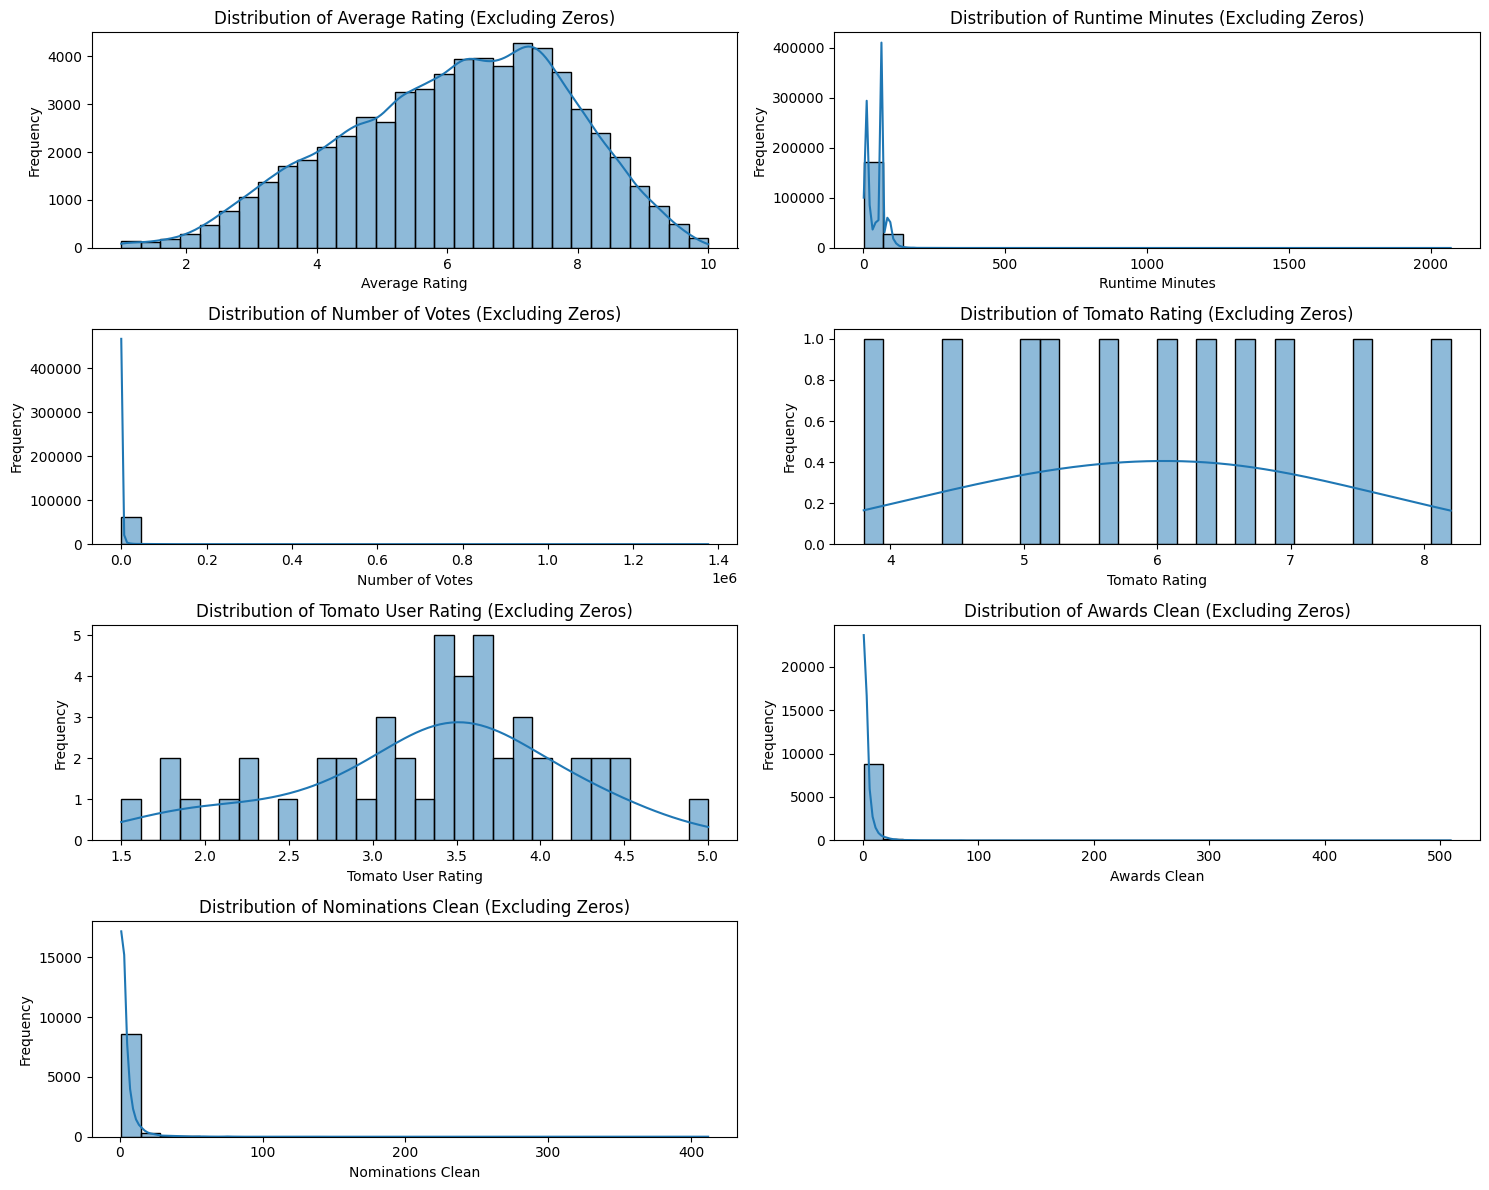

In [87]:
# Filter out values equal to 0 for plotting
filtered_averageRating = data_raw[data_raw['averageRating'] > 0]['averageRating']
filtered_runtimeMinutes = data_raw[data_raw['runtimeMinutes'] > 0]['runtimeMinutes']
filtered_numVotes = data_raw[data_raw['numVotes'] > 0]['numVotes']
filtered_tomatoRating = data_raw[data_raw['tomatoRating'] > 0]['tomatoRating']
filtered_tomatoUserRating = data_raw[data_raw['tomatoUserRating'] > 0]['tomatoUserRating']
filtered_awardsClean = data_raw[data_raw['awardsClean'] > 0]['awardsClean']
filtered_nominationsClean = data_raw[data_raw['nominationsClean'] > 0]['nominationsClean']

# Set the size of the plots
plt.figure(figsize=(15, 12))

# Plot for averageRating
plt.subplot(4, 2, 1)  # 4 rows, 2 columns, 1st subplot
sns.histplot(filtered_averageRating, kde=True, bins=30)
plt.title('Distribution of Average Rating (Excluding Zeros)')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')

# Plot for runtimeMinutes
plt.subplot(4, 2, 2)  # 4 rows, 2 columns, 2nd subplot
sns.histplot(filtered_runtimeMinutes, kde=True, bins=30)
plt.title('Distribution of Runtime Minutes (Excluding Zeros)')
plt.xlabel('Runtime Minutes')
plt.ylabel('Frequency')

# Plot for numVotes
plt.subplot(4, 2, 3)  # 4 rows, 2 columns, 3rd subplot
sns.histplot(filtered_numVotes, kde=True, bins=30)
plt.title('Distribution of Number of Votes (Excluding Zeros)')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')

# Plot for tomatoRating
plt.subplot(4, 2, 4)  # 4 rows, 2 columns, 4th subplot
sns.histplot(filtered_tomatoRating, kde=True, bins=30)
plt.title('Distribution of Tomato Rating (Excluding Zeros)')
plt.xlabel('Tomato Rating')
plt.ylabel('Frequency')

# Plot for tomatoUserRating
plt.subplot(4, 2, 5)  # 4 rows, 2 columns, 5th subplot
sns.histplot(filtered_tomatoUserRating, kde=True, bins=30)
plt.title('Distribution of Tomato User Rating (Excluding Zeros)')
plt.xlabel('Tomato User Rating')
plt.ylabel('Frequency')

# Plot for awardsClean
plt.subplot(4, 2, 6)  # 4 rows, 2 columns, 6th subplot
sns.histplot(filtered_awardsClean, kde=True, bins=30)
plt.title('Distribution of Awards Clean (Excluding Zeros)')
plt.xlabel('Awards Clean')
plt.ylabel('Frequency')

# Plot for nominationsClean
plt.subplot(4, 2, 7)  # 4 rows, 2 columns, 7th subplot
sns.histplot(filtered_nominationsClean, kde=True, bins=30)
plt.title('Distribution of Nominations Clean (Excluding Zeros)')
plt.xlabel('Nominations Clean')
plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

We see, that distribution of average rating for IMDB is slighftly scewed to the right, and stays between 6 and 7. For other Data sorces we don't have a lot of data for significant correlations supposition.

In general horror movies are not so popular and are not awarded much.

<ipython-input-90-a0436c26d3b0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=combined_subgenres, order=combined_subgenres.value_counts().index, palette='viridis')


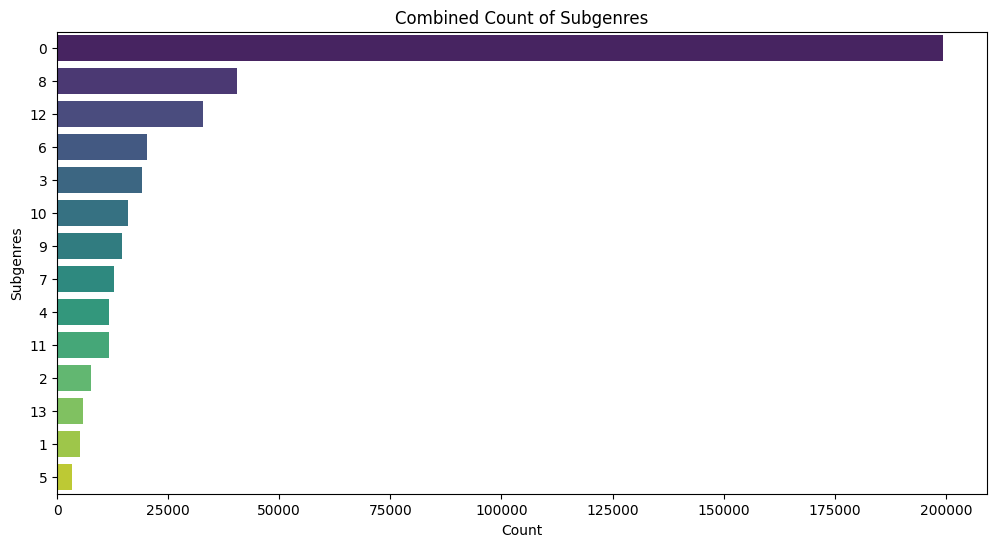

In [90]:
# Combine subgenres into a single Series
combined_subgenres = pd.concat([data_raw['subgenre1'], data_raw['subgenre2']])

# Create a count plot for combined subgenres
plt.figure(figsize=(12, 6))
sns.countplot(y=combined_subgenres, order=combined_subgenres.value_counts().index, palette='viridis')
plt.title('Combined Count of Subgenres')
plt.xlabel('Count')
plt.ylabel('Subgenres')
plt.show()

The most frequent subgenres are number 8, 12 and 6. 0 is for values without data or not detected

<ipython-input-88-951b4f7e529b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=combined_themes, order=combined_themes.value_counts().index, palette='viridis')


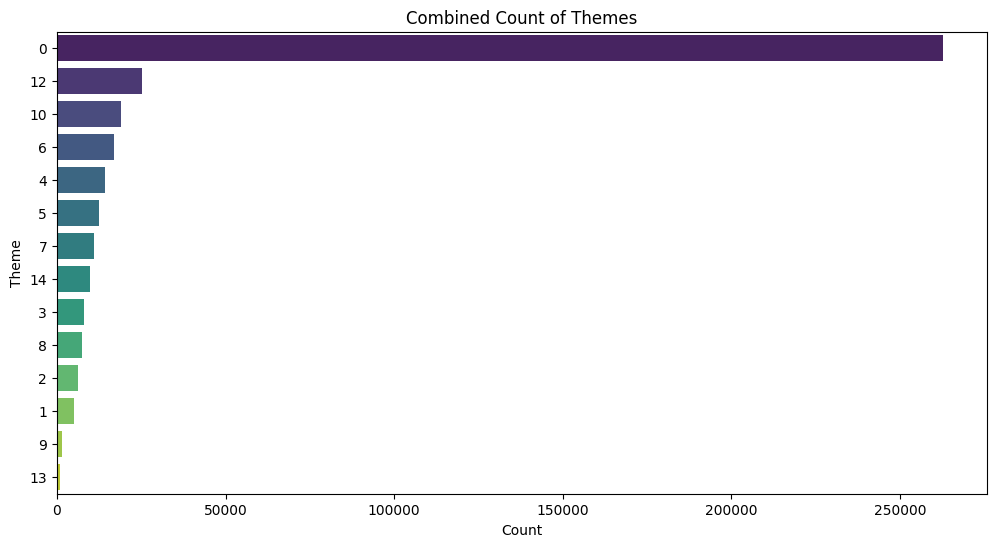

In [88]:
# Combine themes into a single Series
combined_themes = pd.concat([data_raw['theme1'], data_raw['theme2']])

# Create a count plot for combined themes
plt.figure(figsize=(12, 6))
sns.countplot(y=combined_themes, order=combined_themes.value_counts().index, palette='viridis')
plt.title('Combined Count of Themes')
plt.xlabel('Count')
plt.ylabel('Theme')
plt.show()

As we can see, the most popular themes are 12, 10 and 6. For 0 value is the same, as for genres plot

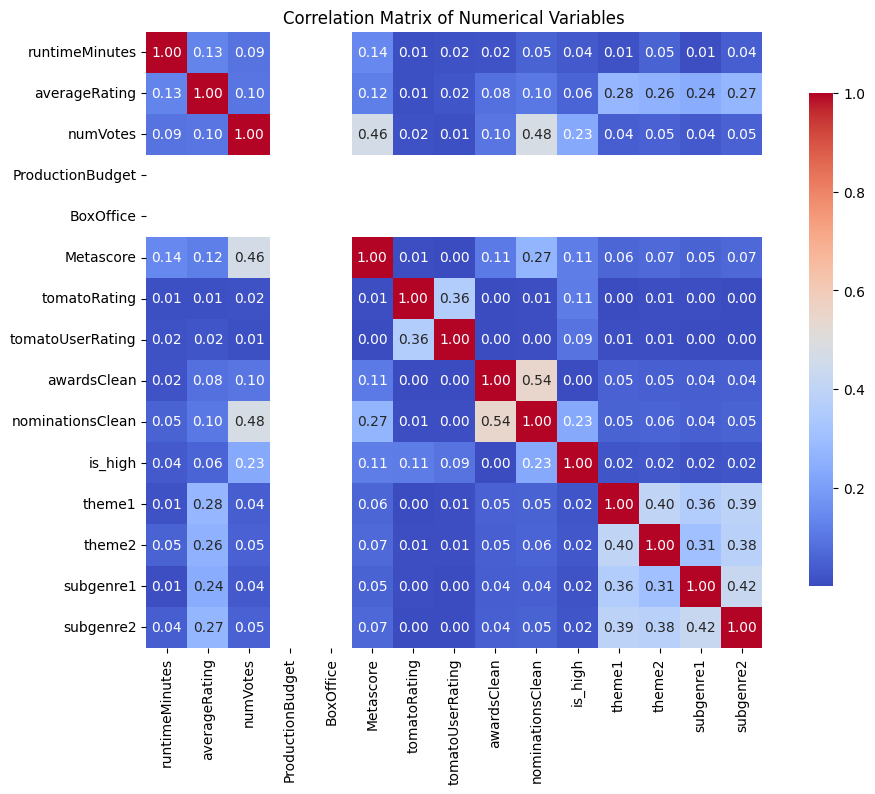

In [95]:
# Compute the correlation matrix
correlation_matrix = numerical_columns_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Title and labels
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

We can notice interesting correlations, to be studied - the first one - between ganres, theme and average raitings, the second one - between number of votes on IMDb and  a Metascore rating, and also number of votes and number of nominations.  

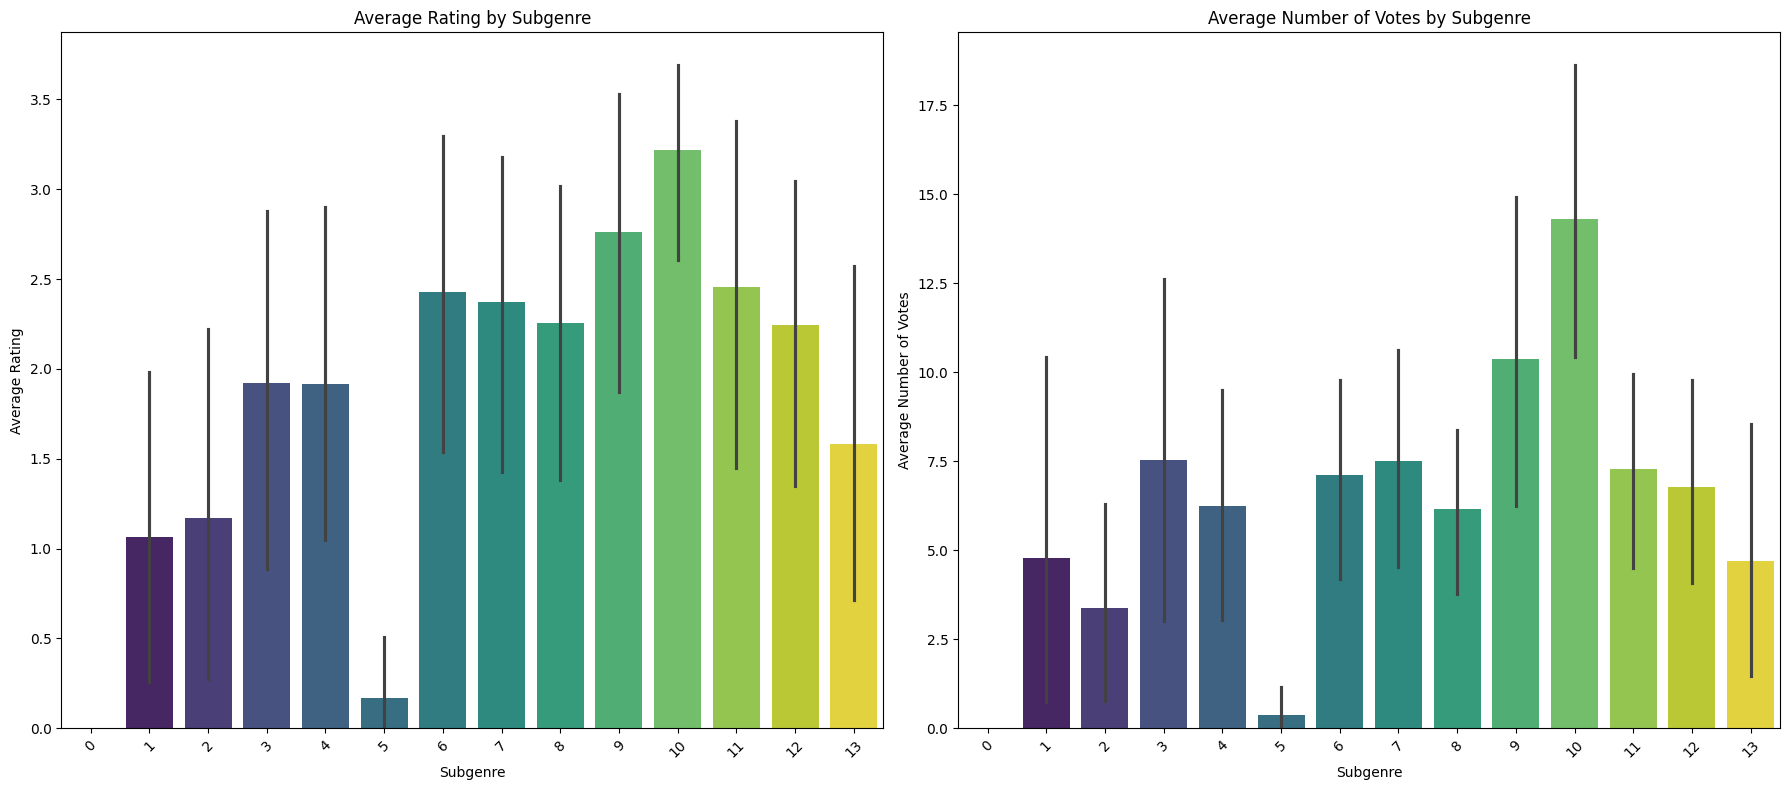

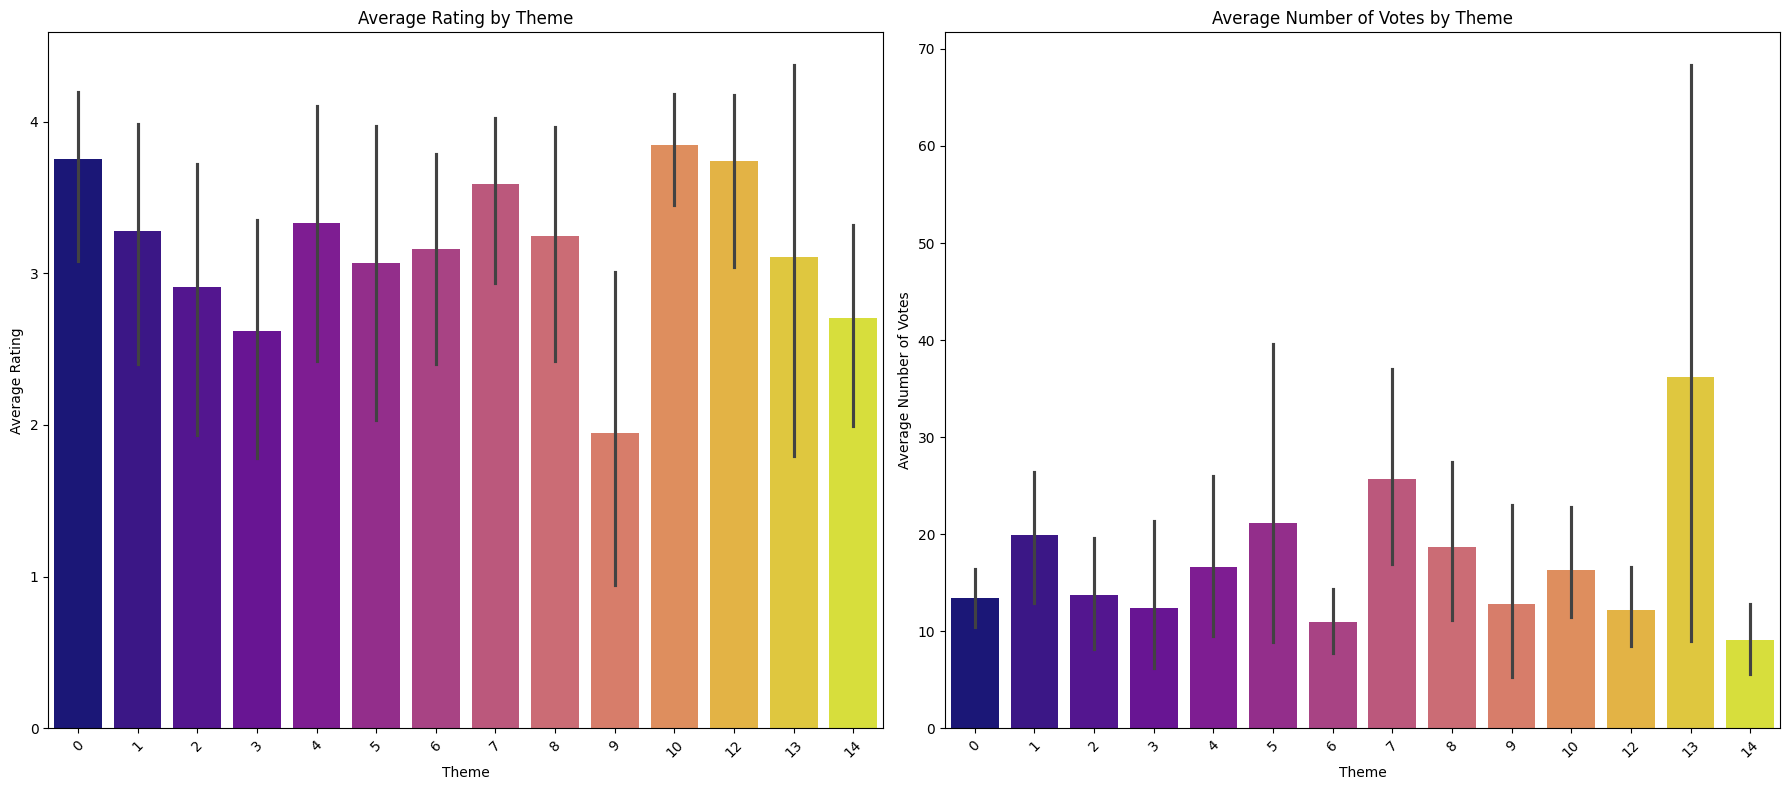

In [97]:


# Group by subgenres and calculate the mean of averageRating and numVotes
subgenre_performance = data_raw.groupby(['subgenre1', 'subgenre2']).agg({
    'averageRating': 'median',
    'numVotes': 'median'
}).reset_index()

# Group by themes and calculate the mean of averageRating and numVotes
theme_performance = data_raw.groupby(['theme1', 'theme2']).agg({
    'averageRating': 'median',
    'numVotes': 'median'
}).reset_index()

# Set up the matplotlib figure for subgenres
plt.figure(figsize=(18, 8))

# Bar plot for averageRating by subgenres
plt.subplot(1, 2, 1)
sns.barplot(data=subgenre_performance, x='subgenre1', y='averageRating', hue='subgenre1', palette='viridis', legend=False)
plt.title('Average Rating by Subgenre')
plt.xticks(rotation=45)
plt.xlabel('Subgenre')
plt.ylabel('Average Rating')

# Bar plot for numVotes by subgenres
plt.subplot(1, 2, 2)
sns.barplot(data=subgenre_performance, x='subgenre1', y='numVotes', hue='subgenre1', palette='viridis', legend=False)
plt.title('Average Number of Votes by Subgenre')
plt.xticks(rotation=45)
plt.xlabel('Subgenre')
plt.ylabel('Average Number of Votes')

plt.tight_layout()
plt.show()

# Set up the matplotlib figure for themes
plt.figure(figsize=(18, 8))

# Bar plot for averageRating by themes
plt.subplot(1, 2, 1)
sns.barplot(data=theme_performance, x='theme1', y='averageRating', hue='theme1', palette='plasma', legend=False)
plt.title('Average Rating by Theme')
plt.xticks(rotation=45)
plt.xlabel('Theme')
plt.ylabel('Average Rating')

# Bar plot for numVotes by themes
plt.subplot(1, 2, 2)
sns.barplot(data=theme_performance, x='theme1', y='numVotes', hue='theme1', palette='plasma', legend=False)
plt.title('Average Number of Votes by Theme')
plt.xticks(rotation=45)
plt.xlabel('Theme')
plt.ylabel('Average Number of Votes')

plt.tight_layout()
plt.show()



For subgenres the most impressive and appreciated is number 10. For themes the highest rating has genre number 10, and the most impressive is number 13.

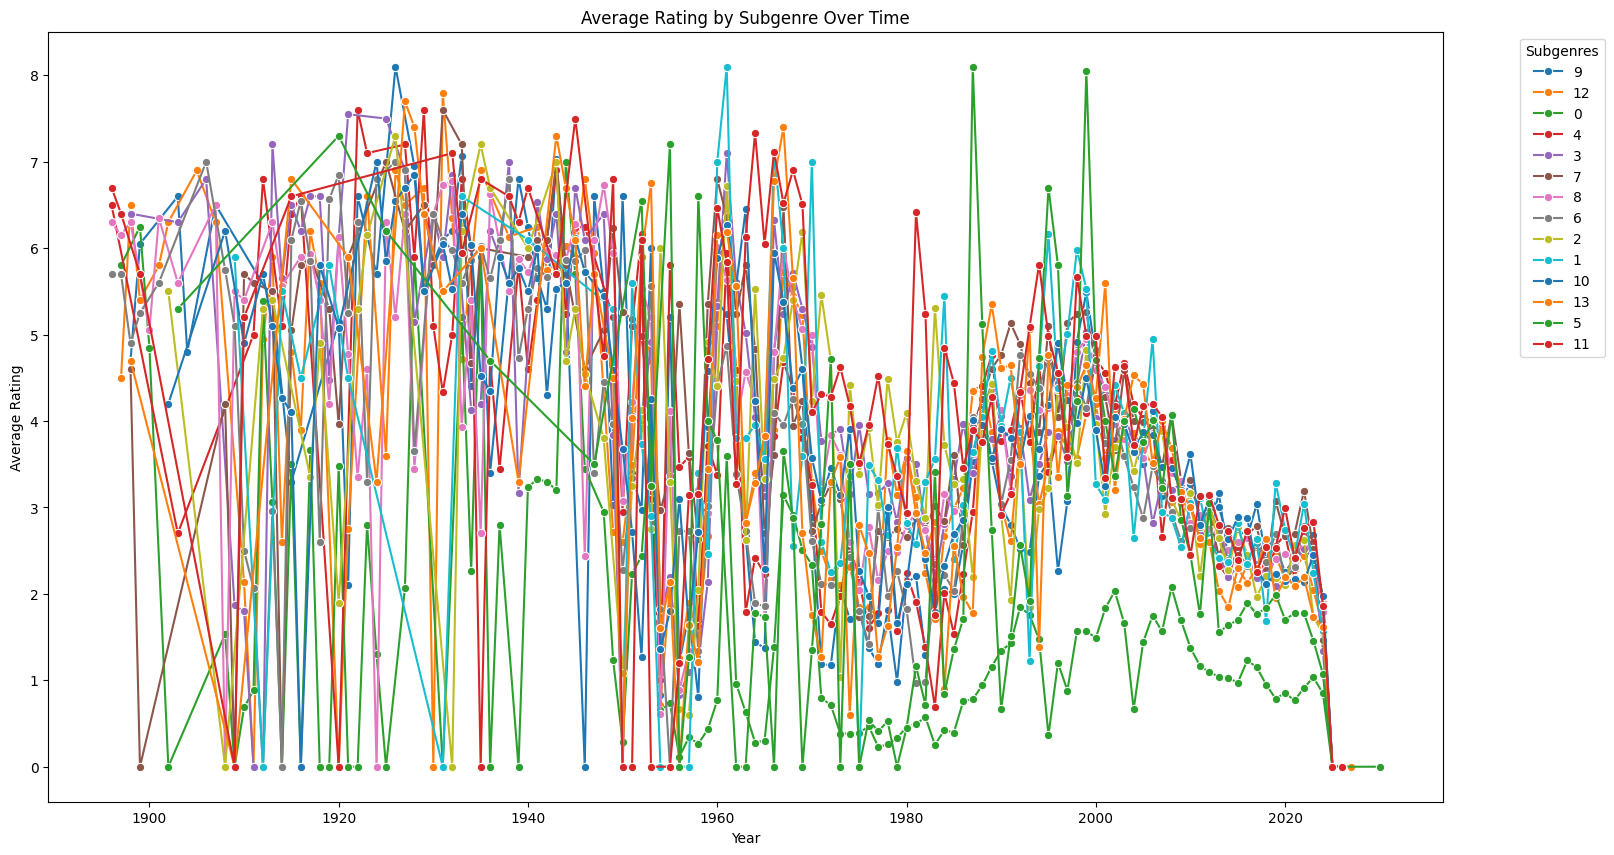

In [98]:
# Grouping by startYear and subgenres to analyze trends
subgenre_performance = data_raw.groupby(['startYear', 'subgenre1']).agg({
    'averageRating': 'mean',
}).reset_index()

# Set up the matplotlib figure for trends in subgenres
plt.figure(figsize=(18, 10))

# Line plot for averageRating by subgenre over time
for subgenre in data_raw['subgenre1'].unique():
    subgenre_data = subgenre_performance[subgenre_performance['subgenre1'] == subgenre]
    sns.lineplot(data=subgenre_data, x='startYear', y='averageRating', label=subgenre, marker='o')

plt.title('Average Rating by Subgenre Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.legend(title='Subgenres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

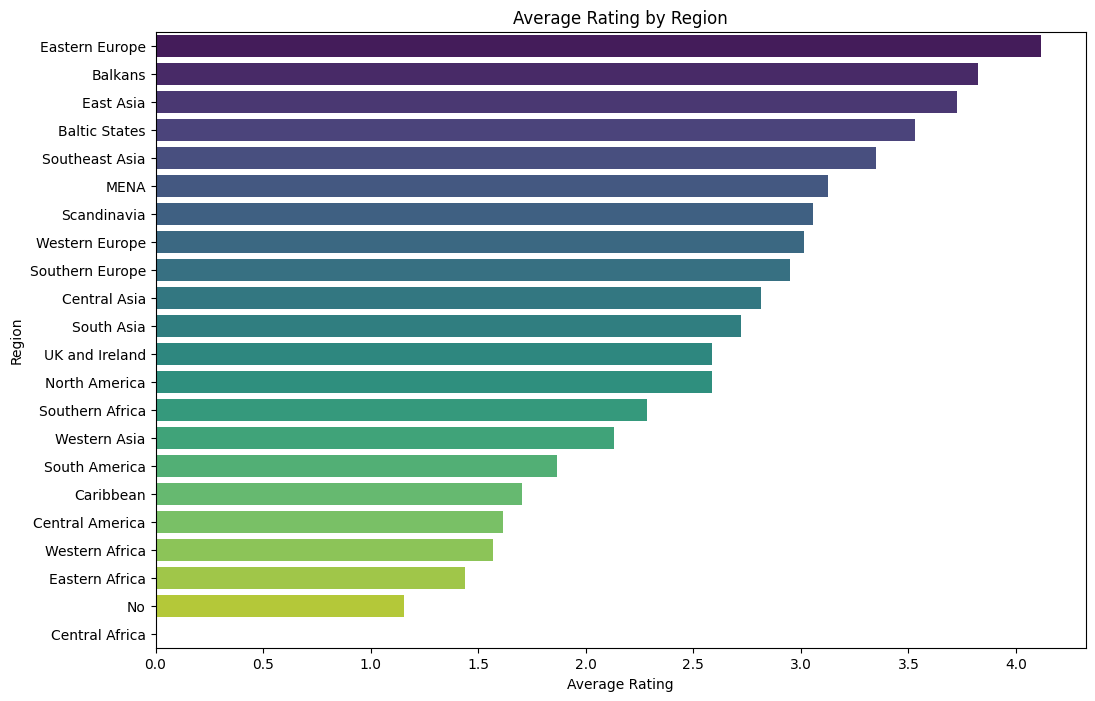

''

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Grouping by Region to analyze average ratings
region_performance = data_raw.groupby('Region').agg({
    'averageRating': 'mean',
}).reset_index()

# Sort the regions by average rating for better visualization
region_performance = region_performance.sort_values(by='averageRating', ascending=False)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a bar plot for average rating by Region
sns.barplot(data=region_performance, x='averageRating', y='Region',hue='Region', palette='viridis', legend=False)

# Title and labels
plt.title('Average Rating by Region')
plt.xlabel('Average Rating')
plt.ylabel('Region')
plt.show()
''


The most highly appreciated are films from eastern europe, Balkans and East Asia.

In [100]:
# Melt the DataFrame to combine theme columns into one
theme_columns = ['theme1', 'theme2']
melted_data = data_raw.melt(
    id_vars=['averageRating'],
    value_vars=theme_columns,
    var_name='theme_type',
    value_name='theme'
)

# Filter out rows with theme value 0 before creating the dictionary
filtered_melted_data = melted_data[melted_data['theme'] != 0]

# Ensure there are at least two themes for comparison
if len(filtered_melted_data['theme'].unique()) < 2:
    print("Error: Not enough unique themes to perform ANOVA.")
else:

    # Now create the dictionary with the filtered data
    theme_ratings = {
        theme: filtered_melted_data[filtered_melted_data['theme'] == theme]['averageRating'].dropna()
        for theme in filtered_melted_data['theme'].unique()
    }

    # Perform ANOVA
    f_statistic, p_value = stats.f_oneway(*theme_ratings.values())

    # Print results
    print("ANOVA results:")
    print(f"F-statistic: {f_statistic}")
    print(f"P-value: {p_value}")

    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        print("There is a significant difference in average ratings among the themes.")
    else:
        print("There is no significant difference in average ratings among the themes.")

ANOVA results:
F-statistic: 29.008010508252976
P-value: 4.34706601622964e-67
There is a significant difference in average ratings among the themes.


In [101]:
# Melt the DataFrame to combine theme columns into one
theme_columns = ['subgenre1', 'subgenre2']
melted_data = data_raw.melt(
    id_vars=['averageRating'],
    value_vars=theme_columns,
    var_name='subgenre_type',
    value_name='subgenre'
)

# Filter out rows with theme value 0 before creating the dictionary
filtered_melted_data = melted_data[melted_data['subgenre'] != 0]

# Ensure there are at least two themes for comparison
if len(filtered_melted_data['subgenre'].unique()) < 2:
    print("Error: Not enough unique themes to perform ANOVA.")
else:

    # Now create the dictionary with the filtered data
    subgenre_ratings = {
        subgenre: filtered_melted_data[filtered_melted_data['subgenre'] == subgenre]['averageRating'].dropna()
        for subgenre in filtered_melted_data['subgenre'].unique()
    }

    # Perform ANOVA
    f_statistic, p_value = stats.f_oneway(*subgenre_ratings.values())

    # Print results
    print("ANOVA results:")
    print(f"F-statistic: {f_statistic}")
    print(f"P-value: {p_value}")

    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        print("There is a significant difference in average ratings among the subgenres.")
    else:
        print("There is no significant difference in average ratings among the subgenres.")

ANOVA results:
F-statistic: 26.015691595118923
P-value: 1.4457559510503651e-59
There is a significant difference in average ratings among the subgenres.


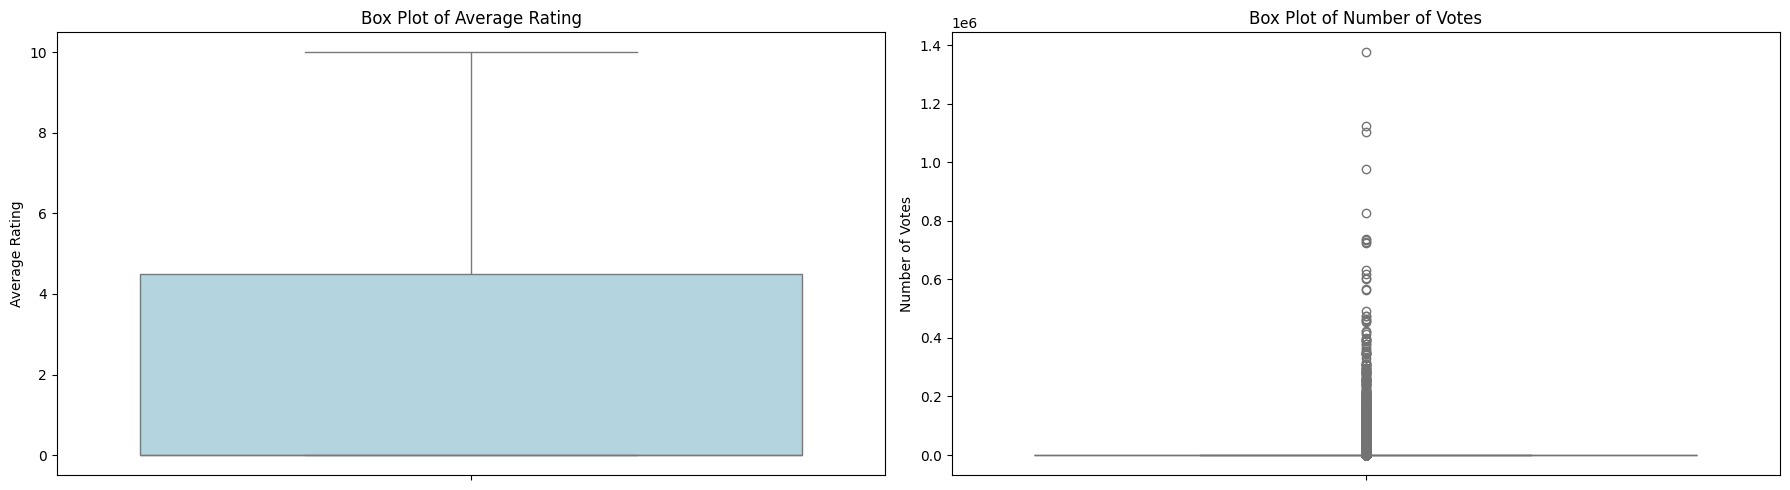

In [102]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 5))

# Box plot for averageRating
plt.subplot(1, 2, 1)
sns.boxplot(data=data_raw, y='averageRating', color='lightblue')
plt.title('Box Plot of Average Rating')
plt.ylabel('Average Rating')

# Box plot for numVotes
plt.subplot(1, 2, 2)
sns.boxplot(data=data_raw, y='numVotes', color='lightgreen')
plt.title('Box Plot of Number of Votes')
plt.ylabel('Number of Votes')



# Show the plots
plt.tight_layout()
plt.show()

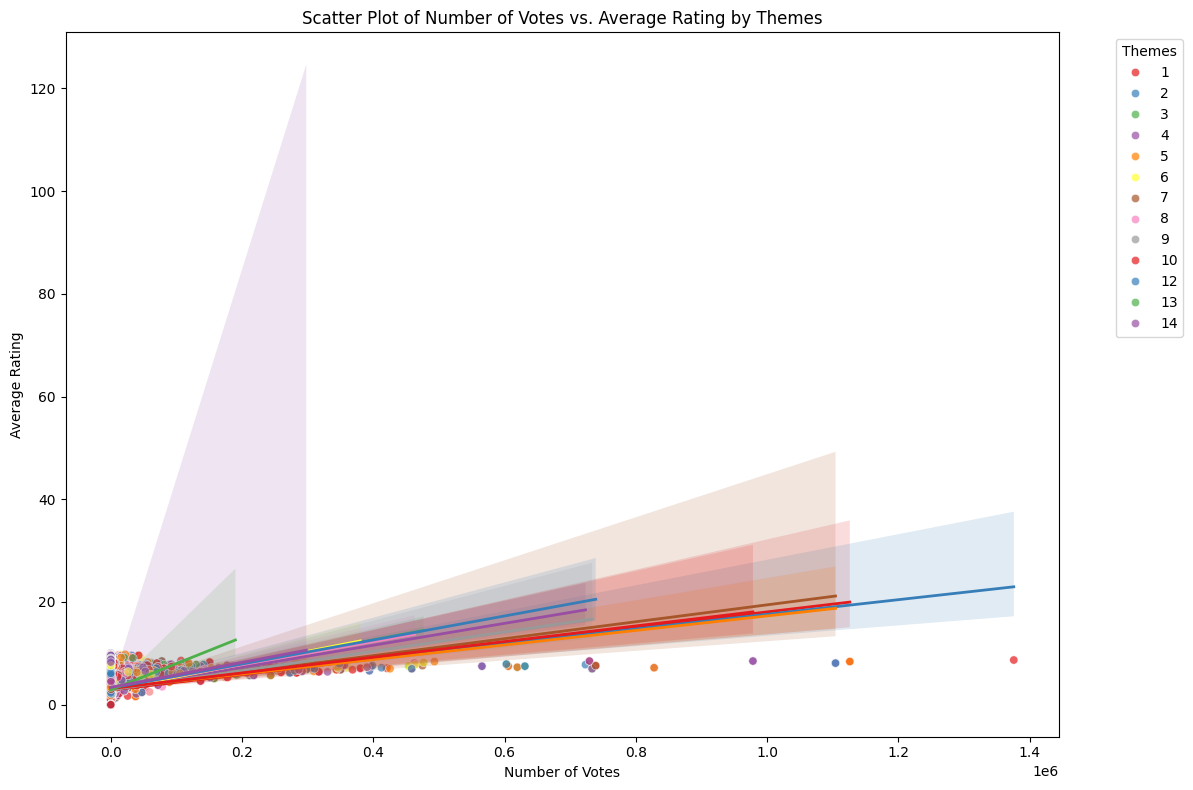

In [103]:
# Melt the DataFrame to long format for themes
melted_data = data_raw.melt(id_vars=['numVotes', 'averageRating'],
                             value_vars=['theme1', 'theme2'],
                             var_name='theme_type',
                             value_name='theme')

# Drop any rows where theme is NaN
melted_data = melted_data.dropna(subset=['theme'])
melted_data = melted_data[melted_data['theme'] != 0]

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Scatter plot for numVotes vs. averageRating, color-coded by theme
sns.scatterplot(data=melted_data, x='numVotes', y='averageRating',
                hue='theme',
                palette='Set1',
                alpha=0.7,
                edgecolor='w')
# Add trendlines for each subgenre, using a cyclic color palette
num_colors = len(sns.color_palette('Set1')) # Get the number of colors in the palette
for i, theme in enumerate(melted_data['theme'].unique()): # Corrected: theme is assigned here
    theme_data = melted_data[melted_data['theme'] == theme]
    sns.regplot(data=theme_data, x='numVotes', y='averageRating',
                scatter=False,
                color=sns.color_palette('Set1')[i % num_colors], # Cycle through the color palette
                line_kws={"linewidth": 2})

# Title and labels
plt.title('Scatter Plot of Number of Votes vs. Average Rating by Themes')
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')

# Show the legend
plt.legend(title='Themes', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

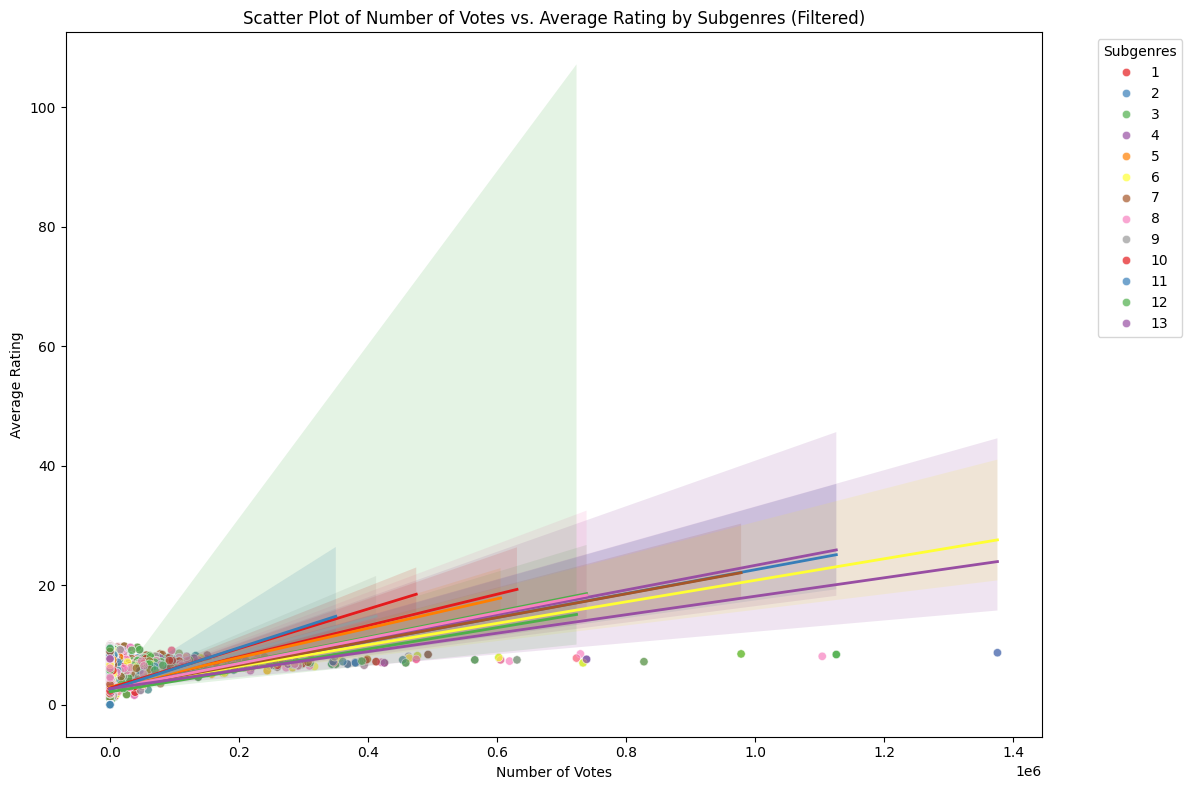

In [104]:
# Melt the DataFrame to long format for subgenres
melted_subgenre_data = data_raw.melt(id_vars=['numVotes', 'averageRating'],
                                       value_vars=['subgenre1', 'subgenre2'],
                                       var_name='subgenre_type',
                                       value_name='subgenre')

# Drop any rows where subgenre is NaN or zero
melted_subgenre_data = melted_subgenre_data.dropna(subset=['subgenre'])
melted_subgenre_data = melted_subgenre_data[melted_subgenre_data['subgenre'] != 0]

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Scatter plot for numVotes vs. averageRating, color-coded by subgenre
sns.scatterplot(data=melted_subgenre_data, x='numVotes', y='averageRating',
                hue='subgenre',
                palette='Set1',  # Using Set1 palette for contrast
                alpha=0.7,
                edgecolor='w')

# Add trendlines for each subgenre, using a cyclic color palette
num_colors = len(sns.color_palette('Set1')) # Get the number of colors in the palette
for i, subgenre in enumerate(melted_subgenre_data['subgenre'].unique()):
    subgenre_data = melted_subgenre_data[melted_subgenre_data['subgenre'] == subgenre]
    sns.regplot(data=subgenre_data, x='numVotes', y='averageRating',
                scatter=False,
                color=sns.color_palette('Set1')[i % num_colors], # Cycle through the color palette
                line_kws={"linewidth": 2})

# Title and labels
plt.title('Scatter Plot of Number of Votes vs. Average Rating by Subgenres (Filtered)')
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')

# Show the legend
plt.legend(title='Subgenres', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

We can notice positive both for themes and genres correlation between number of votes and average rating. more for one themes and genres, less for other themes and genres

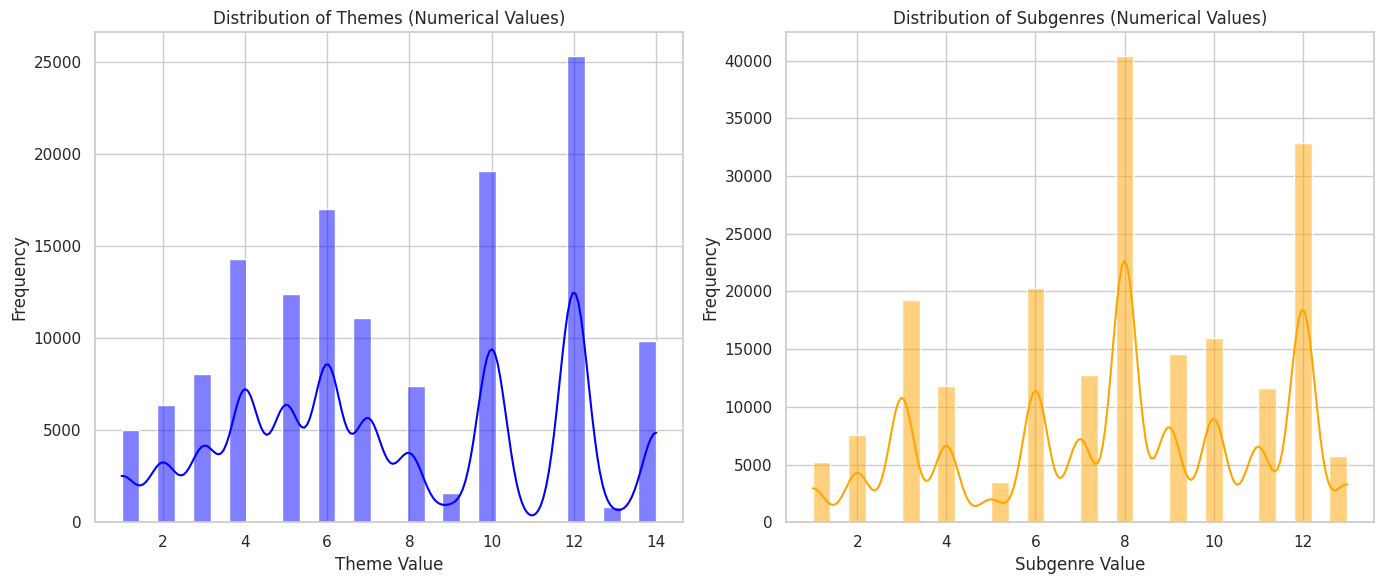

In [105]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Prepare the data for themes and subgenres
theme_columns = ['theme1', 'theme2']
subgenre_columns = ['subgenre1', 'subgenre2']

# Melt the DataFrame to long format for themes
melted_themes = data_raw.melt(value_vars=theme_columns, var_name='theme_type', value_name='theme')

# Melt the DataFrame to long format for subgenres
melted_subgenres = data_raw.melt(value_vars=subgenre_columns, var_name='subgenre_type', value_name='subgenre')

# Drop any rows where theme or subgenre is NaN or zero
melted_themes = melted_themes.dropna(subset=['theme'])
melted_subgenres = melted_subgenres.dropna(subset=['subgenre'])

# Filter out zero values
melted_themes = melted_themes[melted_themes['theme'] != 0]
melted_subgenres = melted_subgenres[melted_subgenres['subgenre'] != 0]

# Set up the matplotlib figure for themes
plt.figure(figsize=(14, 6))

# Histogram for themes
plt.subplot(1, 2, 1)
sns.histplot(melted_themes['theme'], bins=30, kde=True, color='blue')
plt.title('Distribution of Themes (Numerical Values)')
plt.xlabel('Theme Value')
plt.ylabel('Frequency')

# Set up the matplotlib figure for subgenres
plt.subplot(1, 2, 2)
sns.histplot(melted_subgenres['subgenre'], bins=30, kde=True, color='orange')
plt.title('Distribution of Subgenres (Numerical Values)')
plt.xlabel('Subgenre Value')
plt.ylabel('Frequency')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

The most frequent themes are number 12, 10 and 6.

For subgenres it is 8, 12 and 6

In [106]:
data_clean = data_raw.copy()

# Step 1: Clean column names (make lowercase, replace spaces with underscores)
data_clean.columns = data_clean.columns.str.lower().str.replace(' ', '_').str.replace(r'\W', '')

# Step 2: Save the DataFrame as a CSV file for SQL operations
data_clean.to_csv('data_clean.csv', index=False)

print("DataFrame saved as 'data_clean.csv'. Ready for SQL operations.")

DataFrame saved as 'data_clean.csv'. Ready for SQL operations.


#Exploring and preparing actors dataset

In [2]:
# Load the TSV file with low_memory set to False
data_crew = pd.read_csv('/content/name.basics.tsv', sep='\t', low_memory=False)
# Check the first few rows
print(data_crew.head())

NameError: name 'pd' is not defined

In [ ]:
data_crew.isna().sum()

,0
nconst,0
primaryName,8
birthYear,0
deathYear,0
primaryProfession,0
knownForTitles,0


In [ ]:
data_crew.dropna(inplace=True)

Now let's filter the dataset for horror's crew members and create is_actor and is_actress columns for our ordered datasets for Power BI

In [ ]:
# Function to check if at least one tconst is in knownForTitles
def has_matching_tconst(knownForTitles, valid_tconsts):
    # Split the knownForTitles string into a list and check for intersections
    titles = knownForTitles.split(',')
    return any(title in valid_tconsts for title in titles)

# Filter workers based on matching tconsts
valid_tconsts = set(data_clean['tconst'])
filtered_crew = data_crew[data_crew['knownForTitles'].apply(lambda x: has_matching_tconst(x, valid_tconsts))]

# Display the filtered DataFrame
print(filtered_crew.head())

       nconst        primaryName birthYear deathYear  \
11  nm0000012        Bette Davis      1908      1989   
28  nm0000029  Margaux Hemingway      1954      1996   
32  nm0000033   Alfred Hitchcock      1899      1980   
42  nm0000043      Veronica Lake      1922      1973   
76  nm0000077       Franz Waxman      1906      1967   

                        primaryProfession  \
11    actress,make_up_department,producer   
28  actress,miscellaneous,archive_footage   
32               director,producer,writer   
42            actress,producer,soundtrack   
76        music_department,composer,actor   

                             knownForTitles  
11  tt0042192,tt0056687,tt0031210,tt0035140  
28  tt0077800,tt0102122,tt0110138,tt0074802  
32  tt0054215,tt0053125,tt0052357,tt0056869  
42  tt0034240,tt0038369,tt0035432,tt0034881  
76  tt0043014,tt0032976,tt0034248,tt0026138  


In [ ]:
# Create the 'is_actor' and 'is_actress' columns
filtered_crew.loc[:, 'is_actor'] = filtered_crew['primaryProfession'].apply(lambda x: 1 if 'actor' in x else 0)
filtered_crew.loc[:, 'is_actress'] = filtered_crew['primaryProfession'].apply(lambda x: 1 if 'actress' in x else 0)
# Display the updated DataFrame
print(filtered_crew. head())

             nconst                primaryName birthYear deathYear  \
11        nm0000012                Bette Davis      1908      1989   
28        nm0000029          Margaux Hemingway      1954      1996   
32        nm0000033           Alfred Hitchcock      1899      1980   
42        nm0000043              Veronica Lake      1922      1973   
76        nm0000077               Franz Waxman      1906      1967   
...             ...                        ...       ...       ...   
13789799  nm9993540           Annabelle Ducros        \N        \N   
13789863  nm9993614            Yves Desrosiers        \N        \N   
13789868  nm9993619               Sean McManus        \N        \N   
13789920  nm9993680  Christopher-Lawson Palmer        \N        \N   
13789948  nm9993709                  Lu Bevins        \N        \N   

                                      primaryProfession  \
11                  actress,make_up_department,producer   
28                actress,miscellaneous,a

In [ ]:
filtered_crew.to_csv('filtered_crew.csv', index=False)

Let's create a dataset for writers and directors table and filter it for horrors

In [21]:
# Load the TSV file with low_memory set to False
data_direct = pd.read_csv('/content/title.crew.tsv', sep='\t', low_memory=False)
# Check the first few rows
print(data_direct.head())

      tconst  directors writers
0  tt0000001  nm0005690      \N
1  tt0000002  nm0721526      \N
2  tt0000003  nm0721526      \N
3  tt0000004  nm0721526      \N
4  tt0000005  nm0005690      \N


In [ ]:
data_direct.isna().sum()

,0
tconst,0
directors,0
writers,0


In [ ]:
# Filter crew to keep only rows where tconst is in data_clean
filtered_direct = data_direct[data_direct['tconst'].isin(data_clean['tconst'])]

filtered_direct.to_csv('filtered_direct.csv', index=False)

# Quieries processing

Let's move to joining tables for our personality quieries in PowerBI

In [13]:
main_data = pd.read_csv('/content/data_clean.csv')

print(main_data.head())

       tconst                                   primarytitle   startyear  \
0  tt21929830      The Impossible Quiz (2) - RAGE CONTINUES!  2014-01-01   
1  tt21929858  Eyes The Horror Game - CASUAL COMPLETE ENDING  2014-01-01   
2  tt21929878                         A Quick Thank You Vlog  2014-01-01   
3  tt21929954     The Impossible Quiz (3)- Losing My Cool...  2014-01-01   
4  tt21930138          My Top 5 Anime List - BF4 Gameplay #5  2014-01-01   

   runtimeminutes  averagerating  numvotes  productionbudget  boxoffice  \
0            10.0            0.0       0.0               0.0        0.0   
1            12.0            0.0       0.0               0.0        0.0   
2             3.0            0.0       0.0               0.0        0.0   
3             9.0            0.0       0.0               0.0        0.0   
4             9.0            0.0       0.0               0.0        0.0   

  productionstudio country  ...  nominationsclean  is_high  rated_group  \
0               N

In [30]:
crew_data = pd.read_csv('/content/filtered_crew.csv')

print(crew_data.head())

      nconst        primaryName birthYear deathYear  \
0  nm0000012        Bette Davis      1908      1989   
1  nm0000029  Margaux Hemingway      1954      1996   
2  nm0000033   Alfred Hitchcock      1899      1980   
3  nm0000043      Veronica Lake      1922      1973   
4  nm0000077       Franz Waxman      1906      1967   

                       primaryProfession  \
0    actress,make_up_department,producer   
1  actress,miscellaneous,archive_footage   
2               director,producer,writer   
3            actress,producer,soundtrack   
4        music_department,composer,actor   

                            knownForTitles  is_actor  is_actress  
0  tt0042192,tt0056687,tt0031210,tt0035140         0           1  
1  tt0077800,tt0102122,tt0110138,tt0074802         0           1  
2  tt0054215,tt0053125,tt0052357,tt0056869         0           0  
3  tt0034240,tt0038369,tt0035432,tt0034881         0           1  
4  tt0043014,tt0032976,tt0034248,tt0026138         1           0  


In [31]:
actress_data = crew_data[crew_data['is_actress'] == 1]


In [32]:
actress_data.head()


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,is_actor,is_actress
0,nm0000012,Bette Davis,1908,1989,"actress,make_up_department,producer","tt0042192,tt0056687,tt0031210,tt0035140",0,1
1,nm0000029,Margaux Hemingway,1954,1996,"actress,miscellaneous,archive_footage","tt0077800,tt0102122,tt0110138,tt0074802",0,1
3,nm0000043,Veronica Lake,1922,1973,"actress,producer,soundtrack","tt0034240,tt0038369,tt0035432,tt0034881",0,1
6,nm0000099,Patricia Arquette,1968,\N,"actress,producer,director","tt0108399,tt1065073,tt0412175,tt0145531",0,1
8,nm0000103,Fairuza Balk,1974,\N,"actress,soundtrack,archive_footage","tt0115963,tt0181875,tt0089908,tt0120586",0,1


In [33]:
actorss_data = crew_data[crew_data['is_actor'] == 1]

In [34]:
actorss_data.head()


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,is_actor,is_actress
4,nm0000077,Franz Waxman,1906,1967,"music_department,composer,actor","tt0043014,tt0032976,tt0034248,tt0026138",1,0
5,nm0000089,Richard Paul,1940,1998,"actor,soundtrack","tt0117318,tt0075489,tt0088529,tt0076009",1,0
7,nm0000102,Kevin Bacon,1958,\N,"actor,producer,director","tt0087277,tt0164052,tt0361127,tt0327056",1,0
15,nm0000131,John Cusack,1966,\N,"actor,producer,writer","tt0119229,tt0146882,tt0098258,tt0450385",1,0
17,nm0000136,Johnny Depp,1963,\N,"actor,producer,director","tt0408236,tt0325980,tt0449088,tt0383574",1,0


In [36]:
# Step 1: Pre-fetch title and rating data for all tconsts from main_data
def preprocess_main_data(main_data, tconst_col='tconst', title_col='primarytitle', rating_col='averagerating'):
    """
    Preprocess the main_data by selecting only relevant columns and filtering out 0 ratings.
    """
    main_data_reduced = main_data[[tconst_col, title_col, rating_col]].copy()
    main_data_reduced = main_data_reduced[main_data_reduced[rating_col] > 0]  # Filter out 0 ratings
    return main_data_reduced

# Step 2: Efficiently map knownForTitles (tconsts) to titles and ratings for a dataset
def process_single_dataset(main_data_reduced, dataset, known_for_col='knownForTitles', tconst_col='tconst',
                           title_col='primarytitle', rating_col='averagerating', name_col='primaryName'):
    """
    Process a single dataset (e.g., actress_data or actorss_data) to compute median ratings and titles.
    Returns the processed dataset along with the original knownForTitles.
    """
    # Split knownForTitles into a list of tconsts
    dataset = dataset.copy()  # Avoid modifying the original data
    dataset['tconst_list'] = dataset[known_for_col].apply(lambda x: x.split(','))

    # Explode the list of tconsts for easier merging
    exploded_dataset = dataset.explode('tconst_list').copy()

    # Merge to get titles and ratings
    merged_data = exploded_dataset.merge(main_data_reduced, left_on='tconst_list', right_on=tconst_col, how='left')

    # Group by name to compute median rating, collect titles, and retain original knownForTitles
    grouped = merged_data.groupby(name_col).agg(
        medianrating=(rating_col, 'median'),
        titles=(title_col, lambda x: ', '.join(x.dropna())),
        known_for_titles_original=(known_for_col, 'first')  # Get the original knownForTitles
    ).reset_index()

    # Drop rows with missing median rating and sort by median rating
    final_cleaned_table = grouped.dropna(subset=['medianrating']).sort_values(by='medianrating', ascending=False)

    return final_cleaned_table

# Step 3: Create and save separate tables for actress and actor data
def create_and_save_tables(actress_data, actorss_data, main_data, known_for_col='knownForTitles', tconst_col='tconst',
                           title_col='primarytitle', rating_col='averagerating', name_col='primaryName'):
    """
    Generate separate tables for actress and actor names, median ratings, and titles.
    Saves the tables to separate CSV files.
    """
    # Preprocess the main data
    main_data_reduced = preprocess_main_data(main_data, tconst_col, title_col, rating_col)

    # Process actress_data
    actress_ranked_table = process_single_dataset(
        main_data_reduced,
        actress_data,
        known_for_col=known_for_col,
        tconst_col=tconst_col,
        title_col=title_col,
        rating_col=rating_col,
        name_col=name_col
    )

    # Process actorss_data
    actorss_ranked_table = process_single_dataset(
        main_data_reduced,
        actorss_data,
        known_for_col=known_for_col,
        tconst_col=tconst_col,
        title_col=title_col,
        rating_col=rating_col,
        name_col=name_col
    )

    # Save to CSV
    actress_ranked_table.to_csv('actress_ranked_table.csv', index=False)
    actorss_ranked_table.to_csv('actorss_ranked_table.csv', index=False)

    print("Actress table saved as 'actress_ranked_table.csv'")
    print("Actorss table saved as 'actorss_ranked_table.csv'")

    # Optionally return both tables if you need them for further processing
    return actress_ranked_table, actorss_ranked_table

# Use the function
actress_ranked_table, actorss_ranked_table = create_and_save_tables(
    actress_data,
    actorss_data,
    main_data,
    known_for_col='knownForTitles',  # Customize as needed
    tconst_col='tconst',
    title_col='primarytitle',
    rating_col='averagerating',
    name_col='primaryName'
)

# Display sample output
print("Sample output from Actress data:")
print(actress_ranked_table[['primaryName', 'medianrating', 'titles', 'known_for_titles_original']].head())

print("\nSample output from Actorss data:")
print(actorss_ranked_table[['primaryName', 'medianrating', 'titles', 'known_for_titles_original']].head())


Actress table saved as 'actress_ranked_table.csv'
Actorss table saved as 'actorss_ranked_table.csv'
Sample output from Actress data:
            primaryName  medianrating                          titles  \
217483  Victoria Nansen          10.0  The Tale of the Blue Faced Man   
105448    Kaiti Swensen          10.0  The Tale of the Blue Faced Man   
161862     Naomi Nansen          10.0  The Tale of the Blue Faced Man   
9168     Amanda Engleke          10.0                         Cadaver   
162517   Natalie Egbert          10.0  The Tale of the Blue Faced Man   

       known_for_titles_original  
217483                tt33071405  
105448                tt33071405  
161862                tt33071405  
9168                   tt4025846  
162517                tt33071405  

Sample output from Actorss data:
                primaryName  medianrating                          titles  \
319041         Trent Davala          10.0                         Cadaver   
140318  James Michael Cowan   

In [14]:
# Step 1: Pre-fetch title and rating data for all tconsts from main_data
def preprocess_main_data(main_data, tconst_col='tconst', title_col='primarytitle', rating_col='averagerating'):
    """
    Preprocess the main_data by selecting only relevant columns and filtering out 0 ratings.
    """
    main_data_reduced = main_data[[tconst_col, title_col, rating_col]].copy()
    main_data_reduced = main_data_reduced[main_data_reduced[rating_col] > 0]  # Filter out 0 ratings
    return main_data_reduced

In [5]:
filtered_direct = pd.read_csv('/content/filtered_direct.csv')
filtered_direct.head()

,tconst,directors,writers
0,tt0000075,nm0617588,\N
1,tt0000091,nm0617588,nm0617588
2,tt0000131,nm0617588,\N
3,tt0000138,nm0617588,nm0617588
4,tt0000152,nm0617588,\N


In [6]:
# Replace '\N' with NaN in both 'directors' and 'writers' columns
filtered_direct['directors'] = filtered_direct['directors'].replace(r'\\N', np.nan, regex=True)
filtered_direct['writers'] = filtered_direct['writers'].replace(r'\\N', np.nan, regex=True)

In [7]:
def filter_null_in_column(df, col_index):
    """
    Filter out rows with null values in a specific column (by index).
    :param df: The input DataFrame.
    :param col_index: Index of the column to check for null values (default is 2, i.e., the 3rd column).
    :return: DataFrame with rows having null values in the specified column removed.
    """
    # Get the column name based on the index
    col_name = df.columns[col_index]

    # Filter rows where the specific column does not have null values
    filtered_df = df[df[col_name].notnull()]

    return filtered_df

# Creating writers and directors dataframes
filtered_writers = filter_null_in_column(filtered_direct, 2)
print(filtered_writers.head())

filtered_directors = filter_null_in_column(filtered_direct, 1)
print(filtered_directors.head())

       tconst  directors    writers
1   tt0000091  nm0617588  nm0617588
3   tt0000138  nm0617588  nm0617588
11  tt0000211  nm0617588  nm0617588
13  tt0000235  nm0617588  nm0353584
14  tt0000242  nm0617588  nm0617588
      tconst  directors    writers
0  tt0000075  nm0617588        NaN
1  tt0000091  nm0617588  nm0617588
2  tt0000131  nm0617588        NaN
3  tt0000138  nm0617588  nm0617588
4  tt0000152  nm0617588        NaN


In [8]:
# Create a copy to avoid SettingWithCopyWarning
filtered_writers_copy = filtered_writers.copy()
filtered_writers_copy.head()

,tconst,directors,writers
1,tt0000091,nm0617588,nm0617588
3,tt0000138,nm0617588,nm0617588
11,tt0000211,nm0617588,nm0617588
13,tt0000235,nm0617588,nm0353584
14,tt0000242,nm0617588,nm0617588


In [9]:
# Specify the index of the column to delete
column_index_to_delete = 1

# Delete the column by index
filtered_writers_copy.drop(filtered_writers_copy.columns[column_index_to_delete], axis=1, inplace=True)

# Rename the 'writers' column to 'nconst'
# (if you're deleting index 1, make sure the column name exists before this)
filtered_writers_copy.rename(columns={'writers': 'nconst'}, inplace=True)

# Display the updated DataFrame
print("\nUpdated filtered_writers DataFrame:")
print(filtered_writers_copy)


Updated filtered_writers DataFrame:
           tconst                nconst
1       tt0000091             nm0617588
3       tt0000138             nm0617588
11      tt0000211             nm0617588
13      tt0000235             nm0353584
14      tt0000242             nm0617588
...           ...                   ...
185556  tt9915128             nm3220274
185559  tt9915200             nm9176722
185560  tt9915514             nm3966240
185561  tt9915862  nm8871486,nm10538108
185562  tt9916248             nm0196372

[152112 rows x 2 columns]


In [10]:
# Create a copy to avoid SettingWithCopyWarning
filtered_directors_copy = filtered_directors.copy()

# Specify the index of the column to delete
column_index_to_delete = 2

# Delete the column by index
filtered_directors_copy.drop(filtered_directors_copy.columns[column_index_to_delete], axis=1, inplace=True)

# Rename the 'directors' column to 'nconst'
filtered_directors_copy.rename(columns={'directors': 'nconst'}, inplace=True)

# Display the updated DataFrame
print("\nUpdated filtered_directors DataFrame:")
print(filtered_directors_copy)


Updated filtered_directors DataFrame:
           tconst      nconst
0       tt0000075   nm0617588
1       tt0000091   nm0617588
2       tt0000131   nm0617588
3       tt0000138   nm0617588
4       tt0000152   nm0617588
...           ...         ...
185557  tt9915150  nm15597254
185559  tt9915200   nm9176722
185560  tt9915514   nm4132195
185561  tt9915862   nm8871486
185562  tt9916248   nm0739449

[156101 rows x 2 columns]


In [11]:
# Check columns of filtered_directors_copy
print("Filtered Directors Columns:", filtered_directors_copy.columns)

# Check columns of filtered_writers_copy
print("Filtered Writers Columns:", filtered_writers_copy.columns)

# Check for NaN values
print("Filtered Directors nconst NaNs:", filtered_directors_copy['nconst'].isna().sum())
print("Filtered Writers nconst NaNs:", filtered_writers_copy['nconst'].isna().sum())

Filtered Directors Columns: Index(['tconst', 'nconst'], dtype='object')
Filtered Writers Columns: Index(['tconst', 'nconst'], dtype='object')
Filtered Directors nconst NaNs: 0
Filtered Writers nconst NaNs: 0


In [12]:
filtered_crew = pd.read_csv('/content/filtered_crew.csv')
filtered_crew.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,is_actor,is_actress
0,nm0000012,Bette Davis,1908,1989,"actress,make_up_department,producer","tt0042192,tt0056687,tt0031210,tt0035140",0,1
1,nm0000029,Margaux Hemingway,1954,1996,"actress,miscellaneous,archive_footage","tt0077800,tt0102122,tt0110138,tt0074802",0,1
2,nm0000033,Alfred Hitchcock,1899,1980,"director,producer,writer","tt0054215,tt0053125,tt0052357,tt0056869",0,0
3,nm0000043,Veronica Lake,1922,1973,"actress,producer,soundtrack","tt0034240,tt0038369,tt0035432,tt0034881",0,1
4,nm0000077,Franz Waxman,1906,1967,"music_department,composer,actor","tt0043014,tt0032976,tt0034248,tt0026138",1,0


In [27]:
def process_crew_dataset_with_names(main_data_reduced, filtered_data, filtered_crew,
                                     tconst_col='tconst', nconst_col='nconst',
                                     title_col='primarytitle', rating_col='averagerating'):
    """
    Process the filtered directors or writers dataset to compute median ratings and collect titles.
    :param main_data_reduced: Pre-processed main data containing tconst, primarytitle, and averagerating.
    :param filtered_data: Dataset containing tconst and nconst for either directors or writers.
    :param filtered_crew: DataFrame containing crew data with primaryName and knownFor.
    :param tconst_col: Column representing tconst in the filtered dataset.
    :param nconst_col: Column representing nconst (name identifier).
    :param title_col: Column representing the title in main_data_reduced.
    :param rating_col: Column representing the rating in main_data_reduced.
    :return: DataFrame with nconst, primary name, knownFor, list of titles, and median rating.
    """
    # Merge filtered dataset with main_data_reduced on tconst to get title and rating
    merged_data = filtered_data.merge(main_data_reduced, on=tconst_col, how='left')

    # Get the names and knownFor from filtered_crew using nconst
    crew_names = filtered_crew[[nconst_col, 'primaryName', 'knownForTitles']].drop_duplicates()

    # Merge to get the primaryName and knownFor
    merged_data = merged_data.merge(crew_names, on=nconst_col, how='left')

    # Group by nconst to compute median rating and collect titles
    grouped = merged_data.groupby(nconst_col).agg(
        primaryName=('primaryName', 'first'),  # Get the first occurrence
        knownForTitles=('knownForTitles', 'first'),  # Corrected to knownForTitles
        medianrating=(rating_col, 'median'),
        titles=(title_col, lambda x: ', '.join(x.dropna()))
    ).reset_index()

    # Drop rows with missing median rating and sort by median rating
    final_cleaned_table = grouped.dropna(subset=['medianrating']).sort_values(by='medianrating', ascending=False)

    return final_cleaned_table

# Function to create and save tables for directors and writers
def create_and_save_crew_tables(filtered_directors, filtered_writers, filtered_crew, main_data_reduced,
                                tconst_col='tconst', nconst_col='nconst', title_col='primarytitle', rating_col='averagerating'):
    """
    Generate separate tables for directors and writers with their median ratings and titles.
    Saves the directors and writers tables to separate CSV files.
    """
    # Process directors dataset
    directors_ranked_table = process_crew_dataset_with_names(
        main_data_reduced,
        filtered_directors,
        filtered_crew,
        tconst_col=tconst_col,
        nconst_col=nconst_col,
        title_col=title_col,
        rating_col=rating_col
    )

    # Process writers dataset
    writers_ranked_table = process_crew_dataset_with_names(
        main_data_reduced,
        filtered_writers,
        filtered_crew,
        tconst_col=tconst_col,
        nconst_col=nconst_col,
        title_col=title_col,
        rating_col=rating_col
    )

    # Save the directors and writers tables to CSV files
    directors_ranked_table.to_csv('directors_ranked_table.csv', index=False)
    writers_ranked_table.to_csv('writers_ranked_table.csv', index=False)

    print("Directors table saved as 'directors_ranked_table.csv'")
    print("Writers table saved as 'writers_ranked_table.csv'")

    # Optionally return the processed tables for further use
    return directors_ranked_table, writers_ranked_table

# Call the function with your filtered datasets
directors_ranked_table, writers_ranked_table = create_and_save_crew_tables(
    filtered_directors=filtered_directors_copy,  # Updated to the correct name
    filtered_writers=filtered_writers_copy,      # Updated to the correct name
    filtered_crew=filtered_crew,                  # Using filtered_crew as previously
    main_data_reduced=main_data_reduced,
    tconst_col='tconst',
    nconst_col='nconst',
    title_col='primarytitle',
    rating_col='averagerating'
)

# Display a sample output from directors and writers datasets
print("Sample output from Directors data:")
print(directors_ranked_table.head())

print("\nSample output from Writers data:")
print(writers_ranked_table.head())



Directors table saved as 'directors_ranked_table.csv'
Writers table saved as 'writers_ranked_table.csv'
Sample output from Directors data:
                                                  nconst        primaryName  \
26560                                         nm15560426     Harley Coleman   
24122  nm14530489,nm14523665,nm14529908,nm14526417,nm...               None   
46859                                          nm4402944  Scotch Rutherford   
30134                                          nm1877722      Justin Denton   
28240                                         nm16410461      Brandon Price   

                                    knownForTitles  medianrating  \
26560  tt30316956,tt32658187,tt29977916,tt32194853          10.0   
24122                                         None          10.0   
46859    tt32126390,tt30488207,tt4877752,tt3812894          10.0   
30134     tt5605280,tt16898930,tt3485722,tt1440129          10.0   
28240                        tt33071405,tt3308

In [4]:
# Create regional dataframe for more accurate analysis in PowerBI
regions = {
    'MENA': ['Algeria', 'Bahrain', 'Cyprus', 'Egypt', 'Iran', 'Iraq', 'Israel',
             'Jordan', 'Kuwait', 'Lebanon', 'Libya', 'Morocco', 'Oman',
             'Palestine', 'Qatar', 'Saudi Arabia', 'Syria', 'Tunisia', 'Turkey',
             'United Arab Emirates', 'Yemen'],
    'Northern Africa': ['Sudan', 'Western Sahara'],
    'Scandinavia': ['Denmark', 'Finland', 'Iceland', 'Norway', 'Sweden'],
    'Baltic States': ['Estonia', 'Latvia', 'Lithuania'],
    'UK and Ireland': ['Ireland', 'UK'],
    'Balkans': ['Albania', 'Bosnia and Herzegovina', 'Croatia', 'Kosovo', 'Montenegro',
                'North Macedonia', 'Serbia', 'Slovenia'],
    'Southern Europe': ['Andorra', 'Greece', 'Italy', 'Malta', 'Portugal', 'San Marino', 'Spain', 'Vatican City'],
    'Western Europe': ['Austria', 'Belgium', 'France', 'Germany', 'Liechtenstein', 'Luxembourg', 'Monaco', 'Netherlands', 'Switzerland'],
    'Eastern Europe': ['Belarus', 'Bulgaria', 'Czech Republic', 'Hungary', 'Moldova', 'Poland', 'Romania', 'Russia', 'Slovakia', 'Ukraine'],
    'Western Africa': ['Benin', 'Burkina Faso', 'Cape Verde', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
                       'Liberia', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone', 'Togo'],
    'Eastern Africa': ['Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Madagascar', 'Malawi',
                       'Mauritius', 'Mozambique', 'Rwanda', 'Seychelles', 'Somalia', 'South Sudan', 'Tanzania', 'Uganda',
                       'Zambia', 'Zimbabwe'],
    'Central Africa': ['Angola', 'Cameroon', 'Central African Republic', 'Chad', 'Democratic Republic of the Congo',
                       'Republic of the Congo', 'Equatorial Guinea', 'Gabon', 'São Tomé and Príncipe'],
    'Southern Africa': ['Botswana', 'Eswatini', 'Lesotho', 'Namibia', 'South Africa'],
    'North America': ['Canada', 'Mexico', 'US'],
    'Central America': ['Belize', 'Costa Rica', 'El Salvador', 'Guatemala', 'Honduras', 'Nicaragua', 'Panama'],
    'Caribbean': ['Antigua and Barbuda', 'Bahamas', 'Barbados', 'Cuba', 'Dominica', 'Dominican Republic', 'Grenada',
                  'Haiti', 'Jamaica', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines',
                  'Trinidad and Tobago'],
    'South America': ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay',
                      'Peru', 'Suriname', 'Uruguay', 'Venezuela'],
    'East Asia': ['China', 'Japan', 'Mongolia', 'North Korea', 'South Korea', 'Taiwan'],
    'Southeast Asia': ['Brunei', 'Cambodia', 'Indonesia', 'Laos', 'Malaysia', 'Myanmar', 'Philippines',
                       'Singapore', 'Thailand', 'Timor-Leste', 'Vietnam'],
    'South Asia': ['Afghanistan', 'Bangladesh', 'Bhutan', 'India', 'Maldives', 'Nepal', 'Pakistan', 'Sri Lanka'],
    'Central Asia': ['Kazakhstan', 'Kyrgyzstan', 'Tajikistan', 'Turkmenistan', 'Uzbekistan'],
    'Western Asia': ['Armenia', 'Azerbaijan', 'Georgia'],
    'Oceania': ['Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia', 'Nauru', 'New Zealand',
                'Palau', 'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Tonga', 'Tuvalu', 'Vanuatu'],
    'Pacific Islands': ['Cook Islands', 'French Polynesia', 'New Caledonia', 'Niue', 'Pitcairn Islands', 'Tokelau', 'Wallis and Futuna']
}

# Convert the dictionary into a list of tuples (region, country)
data = [(region, country) for region, countries in regions.items() for country in countries]

# Create the DataFrame
df = pd.DataFrame(data, columns=['Region', 'Country'])

# Display the DataFrame
print(df)

df.to_csv('regions.csv', index=False)


              Region            Country
0               MENA            Algeria
1               MENA            Bahrain
2               MENA             Cyprus
3               MENA              Egypt
4               MENA               Iran
..               ...                ...
199  Pacific Islands      New Caledonia
200  Pacific Islands               Niue
201  Pacific Islands   Pitcairn Islands
202  Pacific Islands            Tokelau
203  Pacific Islands  Wallis and Futuna

[204 rows x 2 columns]
